In [1]:
from tqdm import tqdm
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from matplotlib import gridspec
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import geocoder
import datetime
from scipy.stats import norm, describe

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Mounting Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## 01: Timeseries Sample

### Loading extracted NTL data

In [3]:
# data_path = "/content/drive/MyDrive/PhD Physics/4.1/Physics 305 - White Noise Analysis/Project/data/NTL_Metro_Manila.csv"

data_path = "../data/NCR_NTL.csv"

### Read saved CSV file

In [6]:
data = pd.read_csv(data_path, parse_dates=True, index_col = 0)
data.head()

mean
date                 
2012-01-19  21.971253
2012-01-20  28.829778
2012-01-21  19.907287
2012-01-22  18.419685
2012-01-23  18.138900

In [8]:
n_init = len(data)
print("Size of original dataset: %d" % n_init)

Size of original dataset: 2672


### Descriptive statistics

In [14]:
data.describe()

mean
count  2672.000000
mean     22.197319
std       7.085276
min       0.000000
25%      18.736509
50%      22.753863
75%      26.561901
max      76.867673

### Plotting the timeseries data



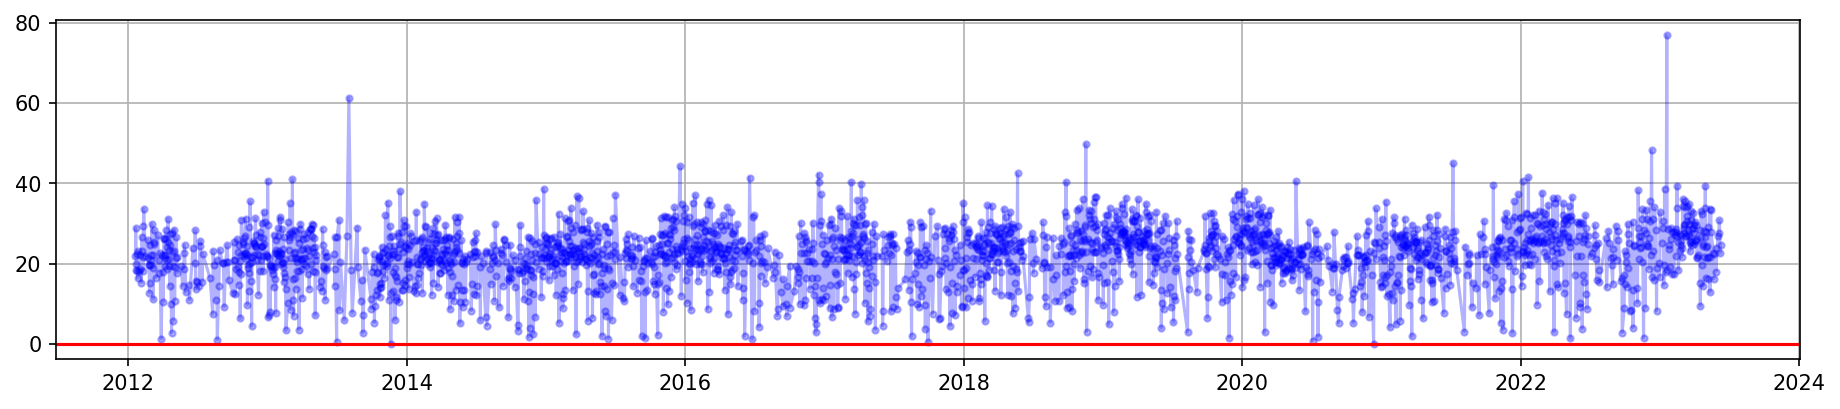

In [5]:
plt.figure(dpi = 150, figsize = (15,3))
plt.grid()
plt.plot(data, 'b.-', alpha = 0.3)
plt.axhline(0, color = 'r')

## Missing datapoints

In [28]:
date_range = pd.date_range(start='2012-01-19', end='2023-06-12', freq='D')

data_reindexed = data.reindex(date_range)
missing_dates = data_reindexed[data_reindexed['mean'].isna()]
print(missing_dates)

            mean
2012-01-27   NaN
2012-01-28   NaN
2012-02-01   NaN
2012-02-02   NaN
2012-02-03   NaN
...          ...
2023-06-06   NaN
2023-06-09   NaN
2023-06-10   NaN
2023-06-11   NaN
2023-06-12   NaN

[1491 rows x 1 columns]


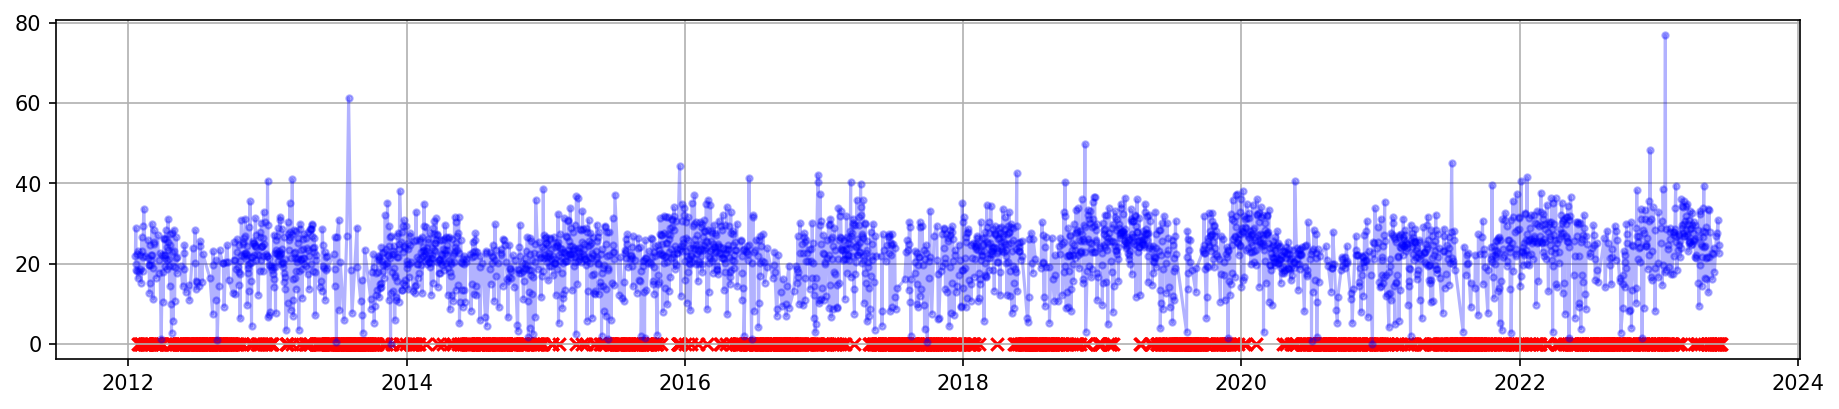

In [34]:
plt.figure(dpi = 150, figsize = (15,3))
plt.grid()
plt.plot(data, 'b.-', alpha = 0.3)
plt.scatter(missing_dates.index, [0] * len(missing_dates), color='red', marker='x', label='Missing Values')

(15358.0, 15458.0)

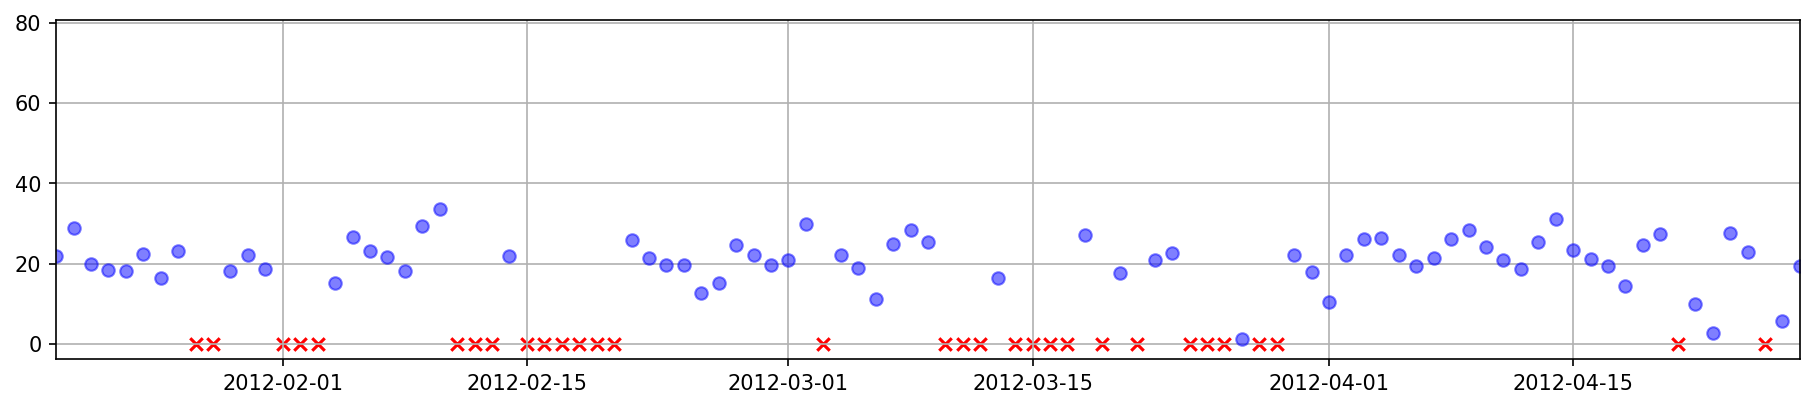

In [52]:
view = 100
plt.figure(dpi = 150, figsize = (15,3))
plt.grid()
plt.plot(data, 'bo', alpha = 0.5)
plt.scatter(missing_dates.index, [0] * len(missing_dates), color='red', marker='x', label='Missing Values')
plt.xlim(date_range[0], date_range[view])

In [43]:
date_range[:10]

DatetimeIndex(['2012-01-19', '2012-01-20', '2012-01-21', '2012-01-22',
               '2012-01-23', '2012-01-24', '2012-01-25', '2012-01-26',
               '2012-01-27', '2012-01-28'],
              dtype='datetime64[ns]', freq='D')

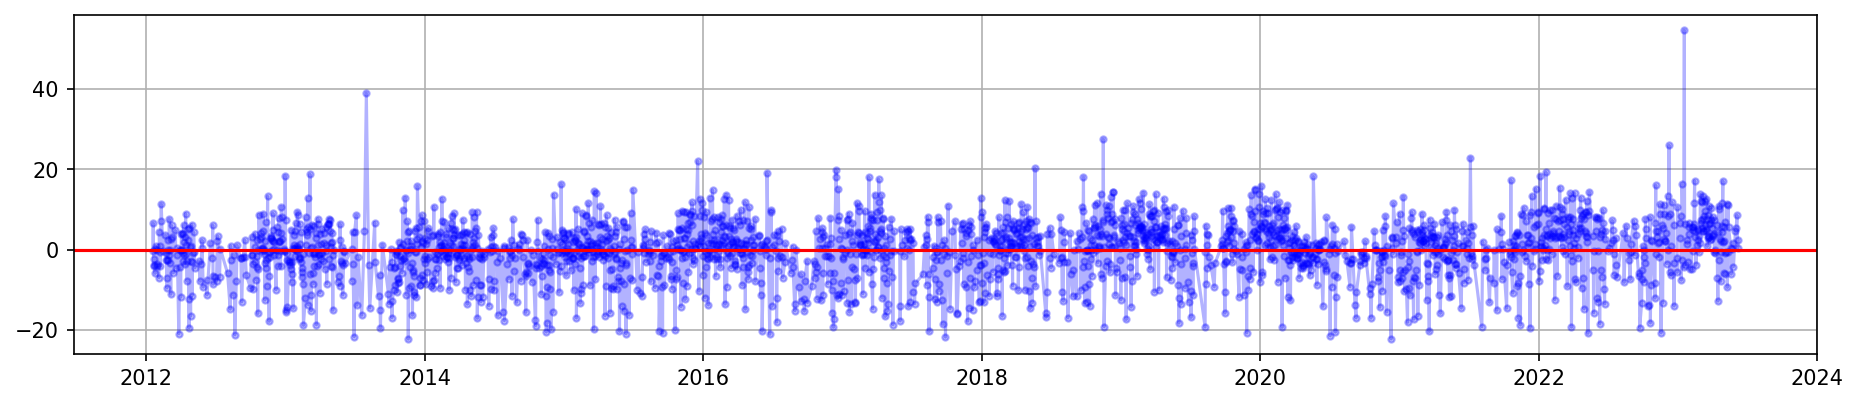

In [6]:
data_mc = data-data.mean()
plt.figure(dpi = 150, figsize = (15,3))
plt.grid()
plt.plot(data_mc, 'b.-', alpha = 0.3)
plt.axhline(0, color = 'r')

## 02: Generate PDF for specific lag time

We select τ - 7 (weekly scale)

In [7]:
tau = 7 #7 days
dt = 1 #1 day interval

delta = int(np.round(tau/dt))
print("tau: %d, Delta: %d" % (tau, delta))

tau: 7, Delta: 7


In [8]:
# get truncated copy of x, ending in initial data point of the last pair
data_trunc = data[:-1*delta]
# get shifted copy of x, starting from end data point of the first pair
data_shift = data[delta:]
# get displacements
dx = data_shift.values - data_trunc.values

In [9]:
len(dx), len(data_trunc), len(data_shift)

(2665, 2665, 2665)

In [10]:
data_trunc.head()

mean
date                 
2012-01-19  21.971253
2012-01-20  28.829778
2012-01-21  19.907287
2012-01-22  18.419685
2012-01-23  18.138900

In [11]:
data_shift.head()

mean
date                 
2012-01-26  23.123943
2012-01-29  18.207923
2012-01-30  22.212970
2012-01-31  18.669379
2012-02-04  15.272858

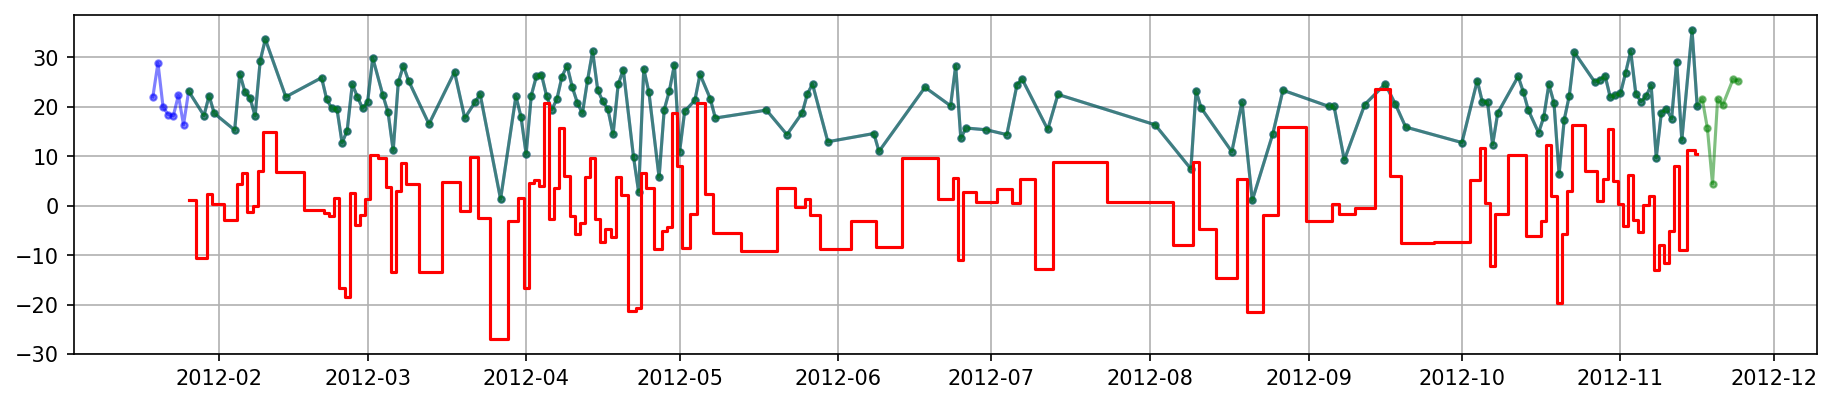

In [12]:
view = 150
plt.figure(dpi = 150, figsize = (15,3))
plt.grid()
plt.plot(data_trunc[:view], 'b.-', alpha = 0.5)
plt.plot(data_shift[:view], 'g.-', alpha = 0.5)
plt.plot(data.index[tau:view], dx[:view-tau], drawstyle = 'steps-mid', color = 'red')

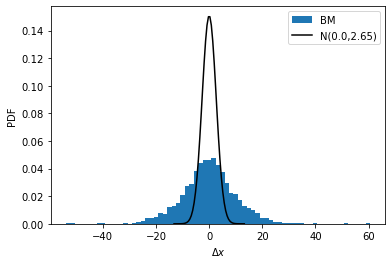

In [13]:
# Generate normal distribution
xx_sd = np.sqrt(tau)
xx = np.linspace(-5, 5)*xx_sd # gridded points from -5 to 5 in units of sd
xx_mean = 0.
yy = norm.pdf(xx, xx_mean, xx_sd)

# Plot PDF of displacements
plt.hist(dx, density=True, bins="auto", label="BM")
plt.xlabel("Delta x")
plt.ylabel("PDF")
# Overlay normal distribution
plt.plot(xx, yy, 'k-', label="N(%.1f,%.2f)" % (xx_mean, xx_sd))
plt.ylabel("PDF")
plt.xlabel(r"$\Delta x$")
plt.legend(loc="best")

In [14]:
tau_vals = np.array([1, 7, 14, 21, 28, 60])
delta_vals = np.round(tau_vals/dt).astype(int)
n = len(data)
n_samp = 1
n_tau = len(tau_vals)
# # initialize array to store displacements
# # note that the size n is larger than the actual number of values to be
# stored
# # values are initialized to NaN (which are not included in the PDF calcu
# lation)
dx_tau = np.empty((n, n_tau))*np.nan
for i, tau in enumerate(tau_vals):
  delta = delta_vals[i]
# get truncated copy of x, ending in initial data point of the last pair
  data_trunc = data[:-1*delta]
# # get shifted copy of x, starting from end data point of the first pair
  data_shift = data[delta:]
# # get displacements
  dx = data_shift.values - data_trunc.values
# # store in output array
  dx_tau[:len(dx), i] = dx.T
# #print(i, tau, delta, len(dx))

In [15]:
# define plotting function
def plot_pdf_bm(dx, tau):
# Generate normal distribution
  xx_mean = 0.
  xx_sd = np.sqrt(tau)
  xx = np.linspace(-5, 5)*xx_sd # gridded points from -5 to 5 in units of sd
  yy = norm.pdf(xx, xx_mean, xx_sd)
  # Plot PDF of displacements
  plt.hist(dx, density=True, bins="auto", label="BM", alpha=0.4)
  plt.xlabel("Delta x")
  plt.ylabel("PDF")
  # Overlay normal distribution
  plt.plot(xx, yy, 'k-', label="N(%.1f,%.2f)" % (xx_mean, xx_sd))
  plt.ylabel("PDF")
  plt.xlabel(r"$\Delta x$")
  #plt.legend(loc="best")
  plt.title(r"$\tau$ = %d days, sd = %.2f" % (tau, xx_sd))

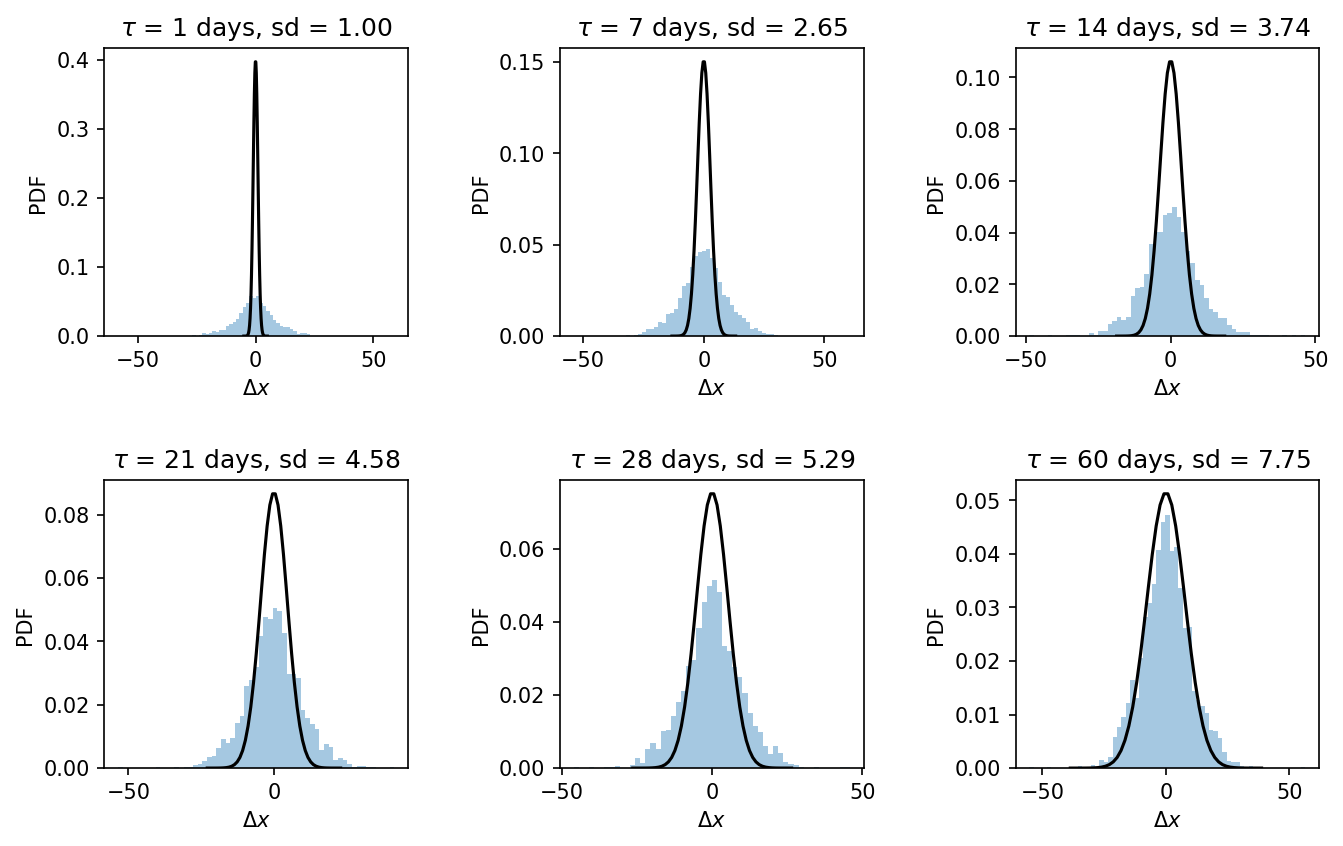

In [16]:
# generate plot for 1 sample

i_samp = 0 # select sample to plot (by index)
plt.figure(figsize=(12,6), dpi = 150)
for i in np.arange(n_tau):
  plt.subplot(2,3,i+1)
  plot_pdf_bm(dx_tau[:,i], tau_vals[i])
  plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=
  0.5)

In [18]:
n_tau = len(data)
# n_tau = 100
tau_vals = np.logspace(0,np.log10(n_tau), n_tau)
delta_vals = np.round(tau_vals/dt).astype(int)

n = len(data)
n_samp = 1
n_tau = len(tau_vals)
# # initialize array to store displacements
# # note that the size n is larger than the actual number of values to be
# stored
# # values are initialized to NaN (which are not included in the PDF calcu
# lation)
dx_tau = np.empty((n, n_tau))*np.nan
for i, tau in tqdm(enumerate(tau_vals)):
  delta = delta_vals[i]
# get truncated copy of x, ending in initial data point of the last pair
  data_trunc = data[:-1*delta]
# # get shifted copy of x, starting from end data point of the first pair
  data_shift = data[delta:]
# # get displacements
  dx = data_shift.values - data_trunc.values
# # store in output array
  dx_tau[:len(dx), i] = dx.T
# #print(i, tau, delta, len(dx))



2672it [00:00, 10959.00it/s]


In [19]:
# initialize array to store MSD values
msd_tau = np.empty((n_tau, n_samp))*np.nan
for i, tau in enumerate(tau_vals):
  dx2_sum = np.nansum(dx_tau[:, i]**2) # returns sum treating NaNs as zero
  denom = n-delta_vals[i]
  msd_tau[i, i_samp] = dx2_sum/denom

In [20]:
np.shape(msd_tau)

(2672, 1)

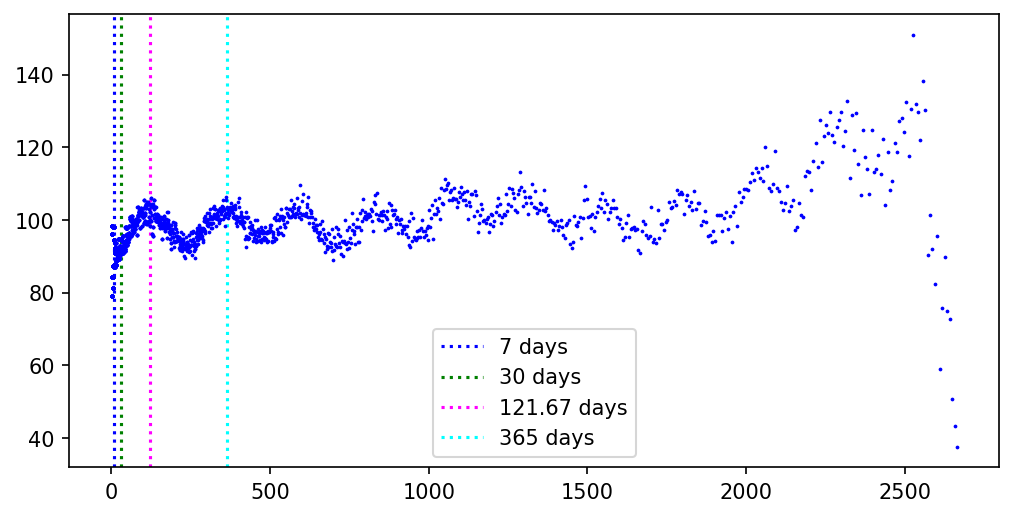

In [21]:
plt.figure(dpi = 150, figsize = (8,4))
# plt.grid()
plt.axvline(7, color='blue', ls=':', label = "7 days")
plt.axvline(30, color='green', ls=':', label = "30 days")
plt.axvline(365/3, color='magenta', ls=':', label = "121.67 days")
plt.axvline(365, color='cyan', ls=':', label = "365 days")
plt.plot(tau_vals, msd_tau, 'bo', ms = 0.8)
plt.legend()

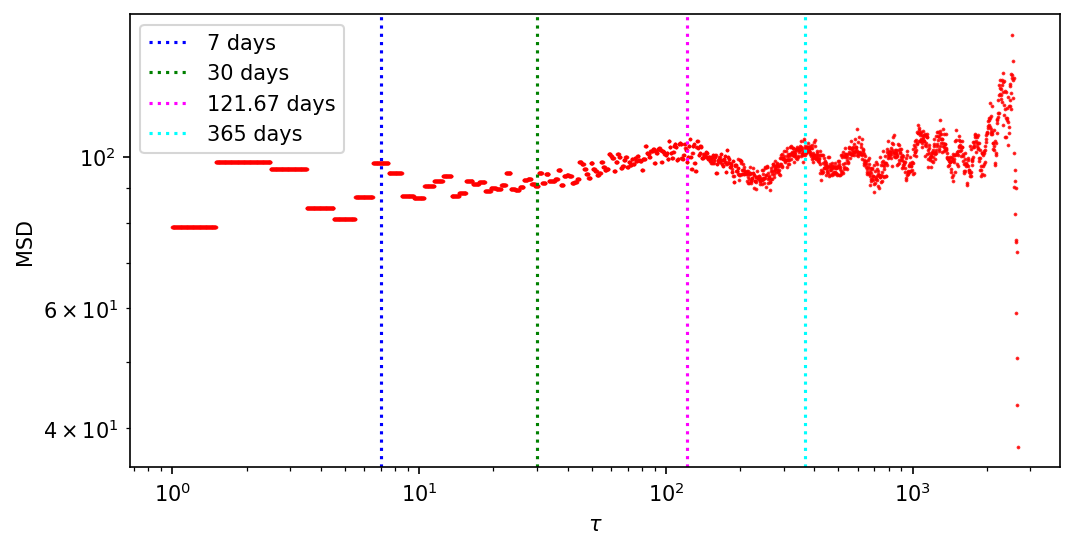

In [22]:
# plot analytical result
plt.figure(dpi = 150, figsize = (8,4))

# plt.grid()
plt.plot(tau_vals, msd_tau, 'ro', alpha = 0.8, ms = 0.8)
# plt.plot(tau_vals, msd_tau, 'k--', alpha = 0.3)
msd_theo = tau_vals
# plt.plot(tau_vals, msd_theo, 'k--')
# plot vertical line at tau=10^3
plt.axvline(7, color='blue', ls=':', label = "7 days")
plt.axvline(30, color='green', ls=':', label = "30 days")
plt.axvline(365/3, color='magenta', ls=':', label = "121.67 days")
plt.axvline(365, color='cyan', ls=':', label = "365 days")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel("MSD")
plt.legend()

In [76]:
import os

data_path = "../data/"
regional_NTL = os.listdir(data_path)
# "../data/

  0%|                                                    | 0/17 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1069it [00:00, 10680.05it/s]
2204it [00:00, 11065.18it/s]
3475it [00:00, 11459.19it/s]
  6%|██▌                                         | 1/17 [00:01<00:17,  1.10s/it]
0it [00:00, ?it/s]
1047it [00:00, 10463.30it/s]
2159it [00:00, 10845.92it/s]
3503it [00:00, 11342.77it/s]
 12%|█████▏                                      | 2/17 [00:02<00:15,  1.06s/it]
0it [00:00, ?it/s]
1157it [00:00, 11567.45it/s]
3375it [00:00, 9668.21it/s] 
 18%|███████▊                                    | 3/17 [00:03<00:15,  1.08s/it]
0it [00:00, ?it/s]
944it [00:00, 9434.05it/s]
1888it [00:00, 9370.98it/s]
3858it [00:00, 10397.88it/s]
 24%|██████████▎                                 | 4/17 [00:04<00:14,  1.13s/it]
0it [00:00, ?it/s]
1049it [00:00, 10481.81it/s]
2177it [00:00, 10943.21it/s]
3645it [00:00, 11394.58it/s]
 29%|████████████▉                               | 5/17 [00:05<00:13,  1.12s/it]
0it [00:00, ?it/

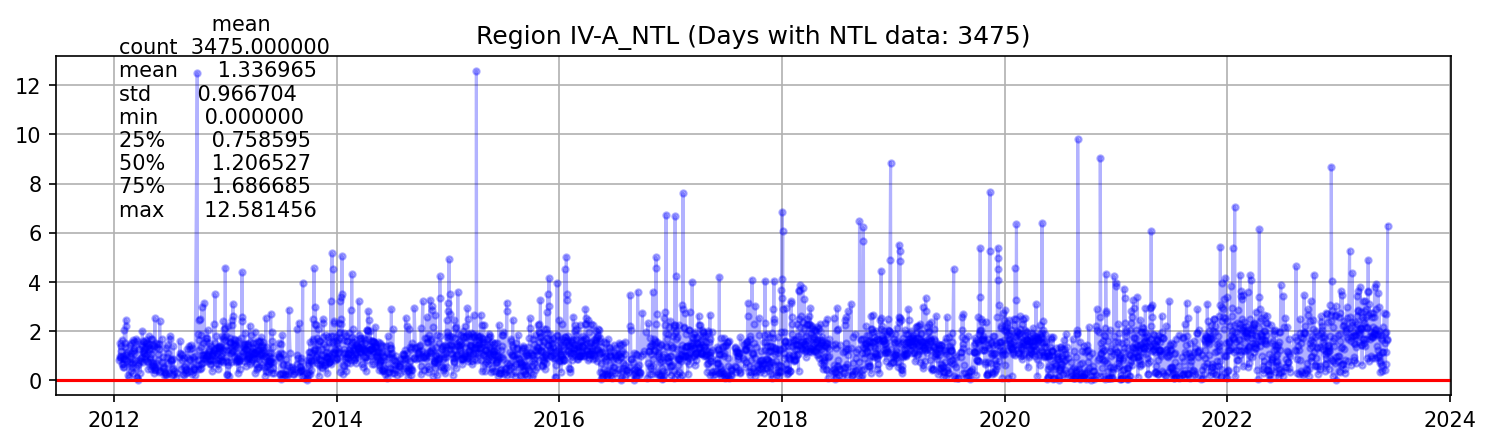

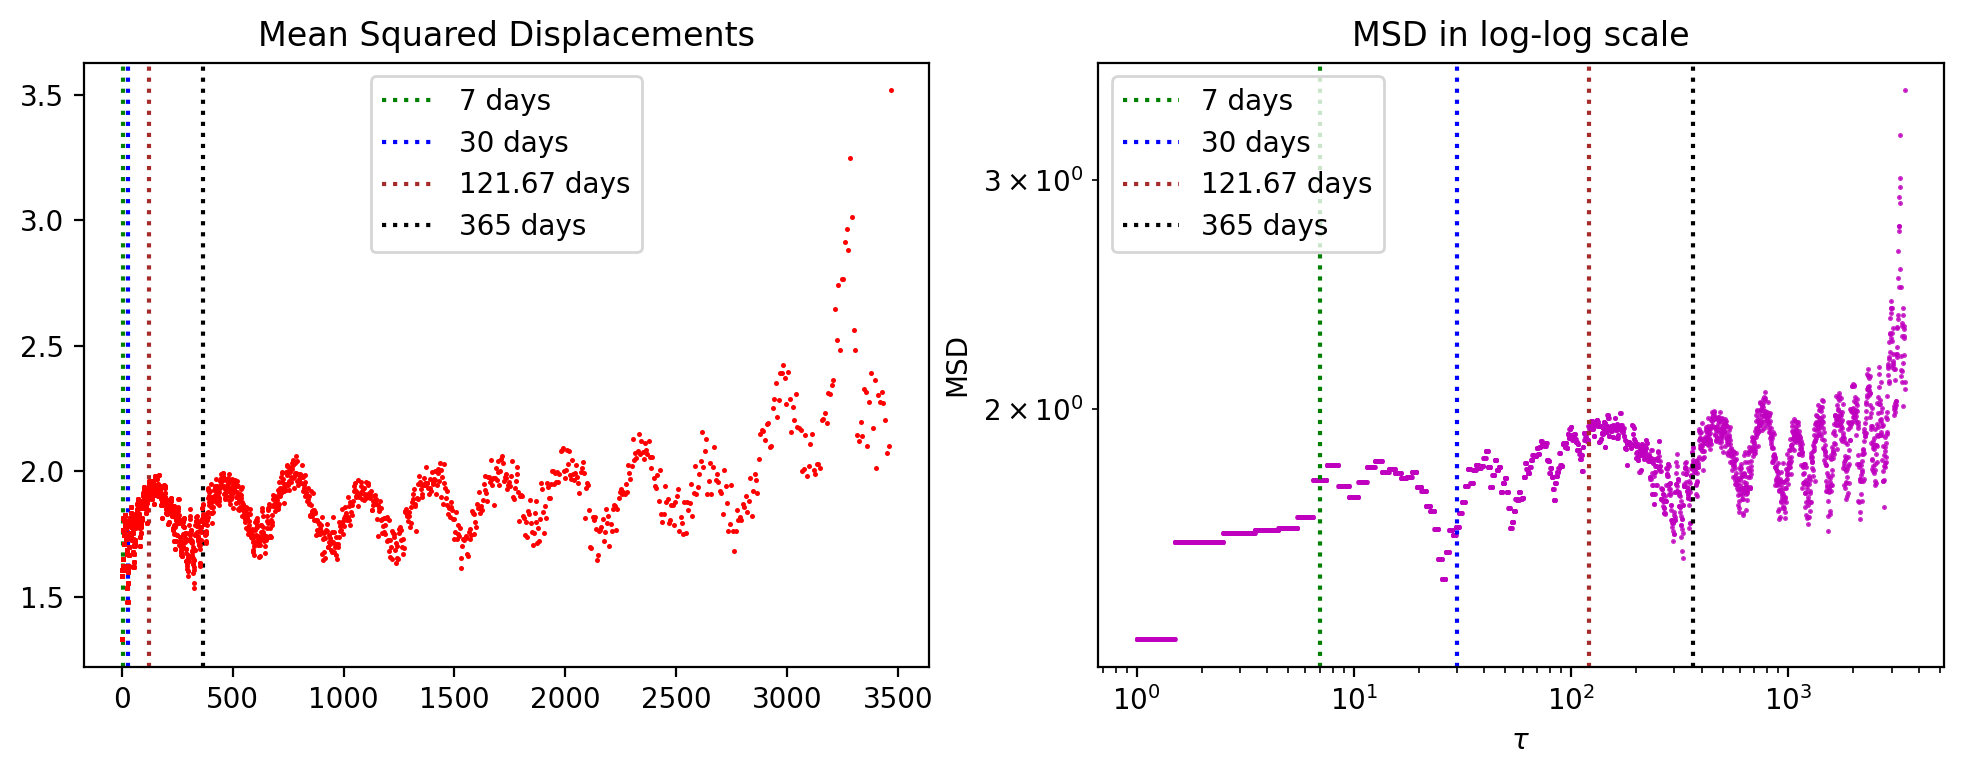

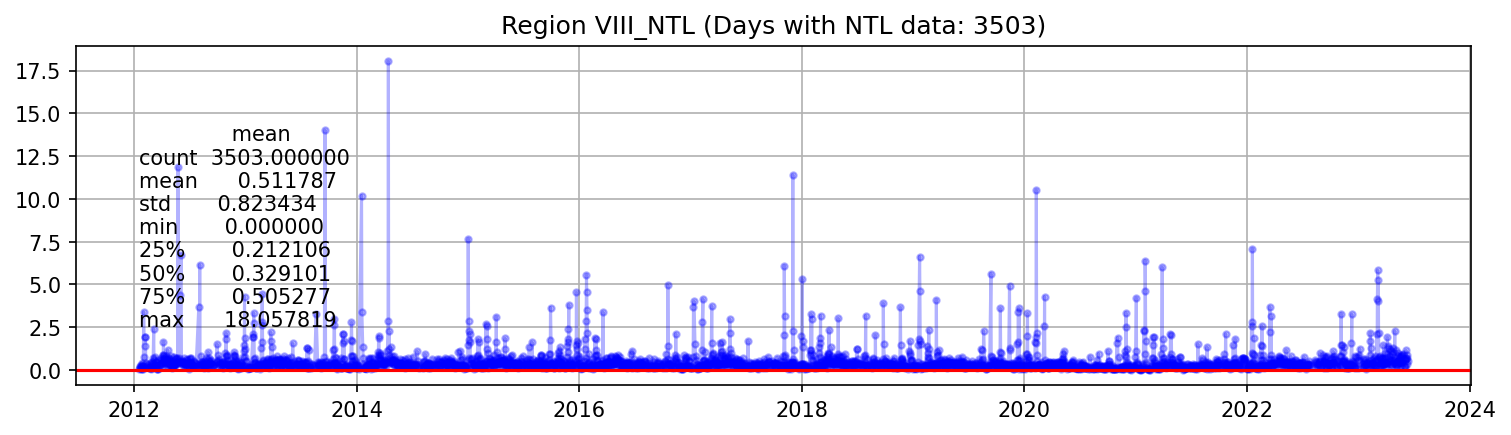

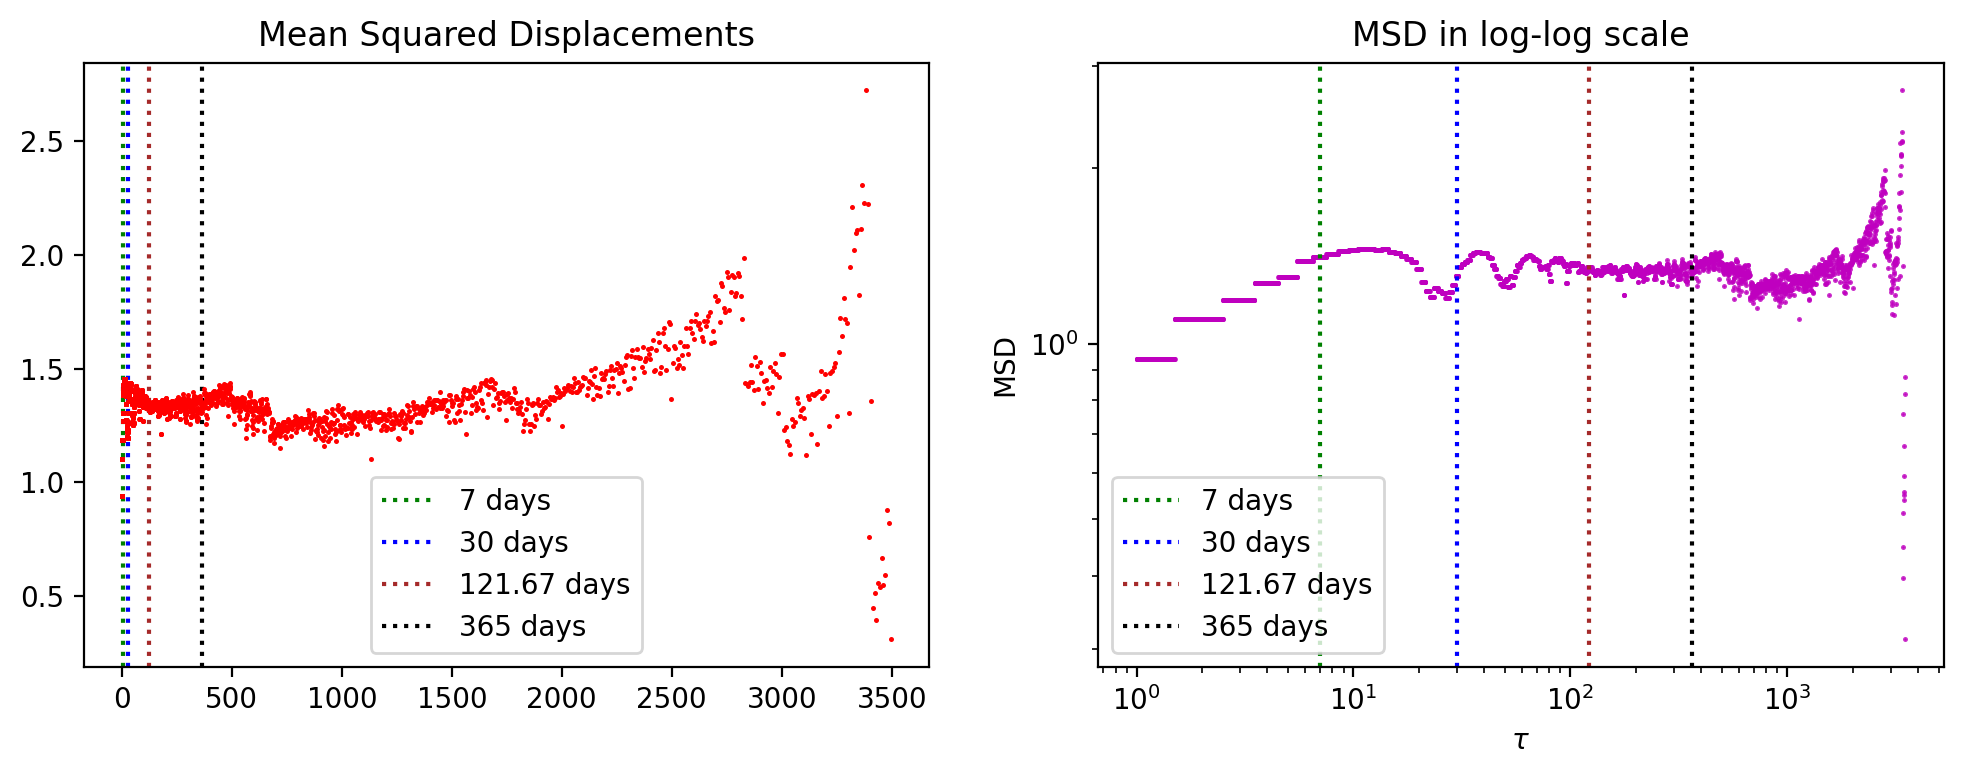

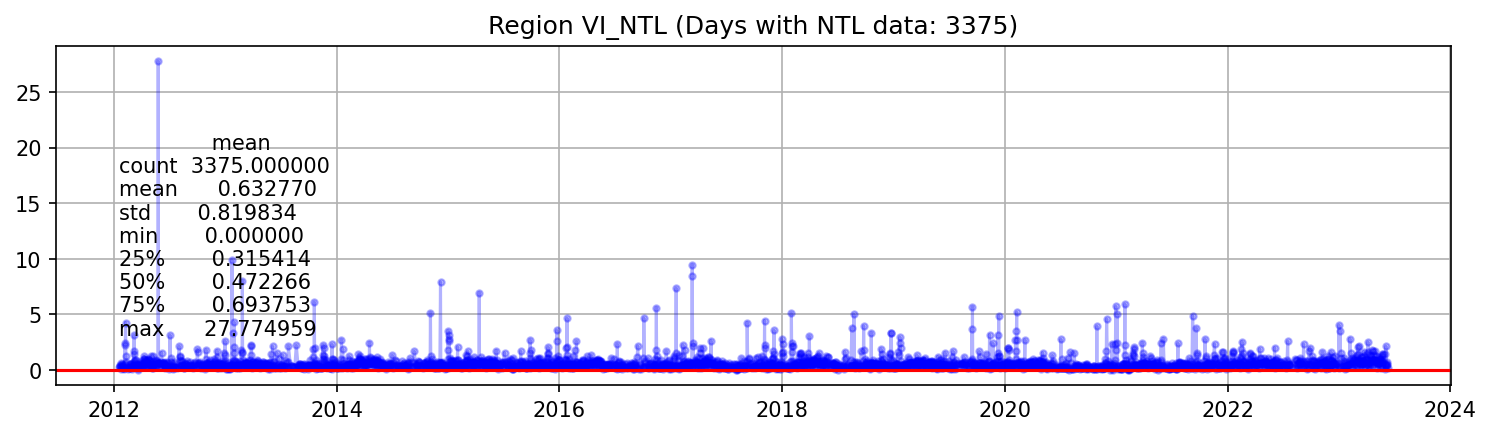

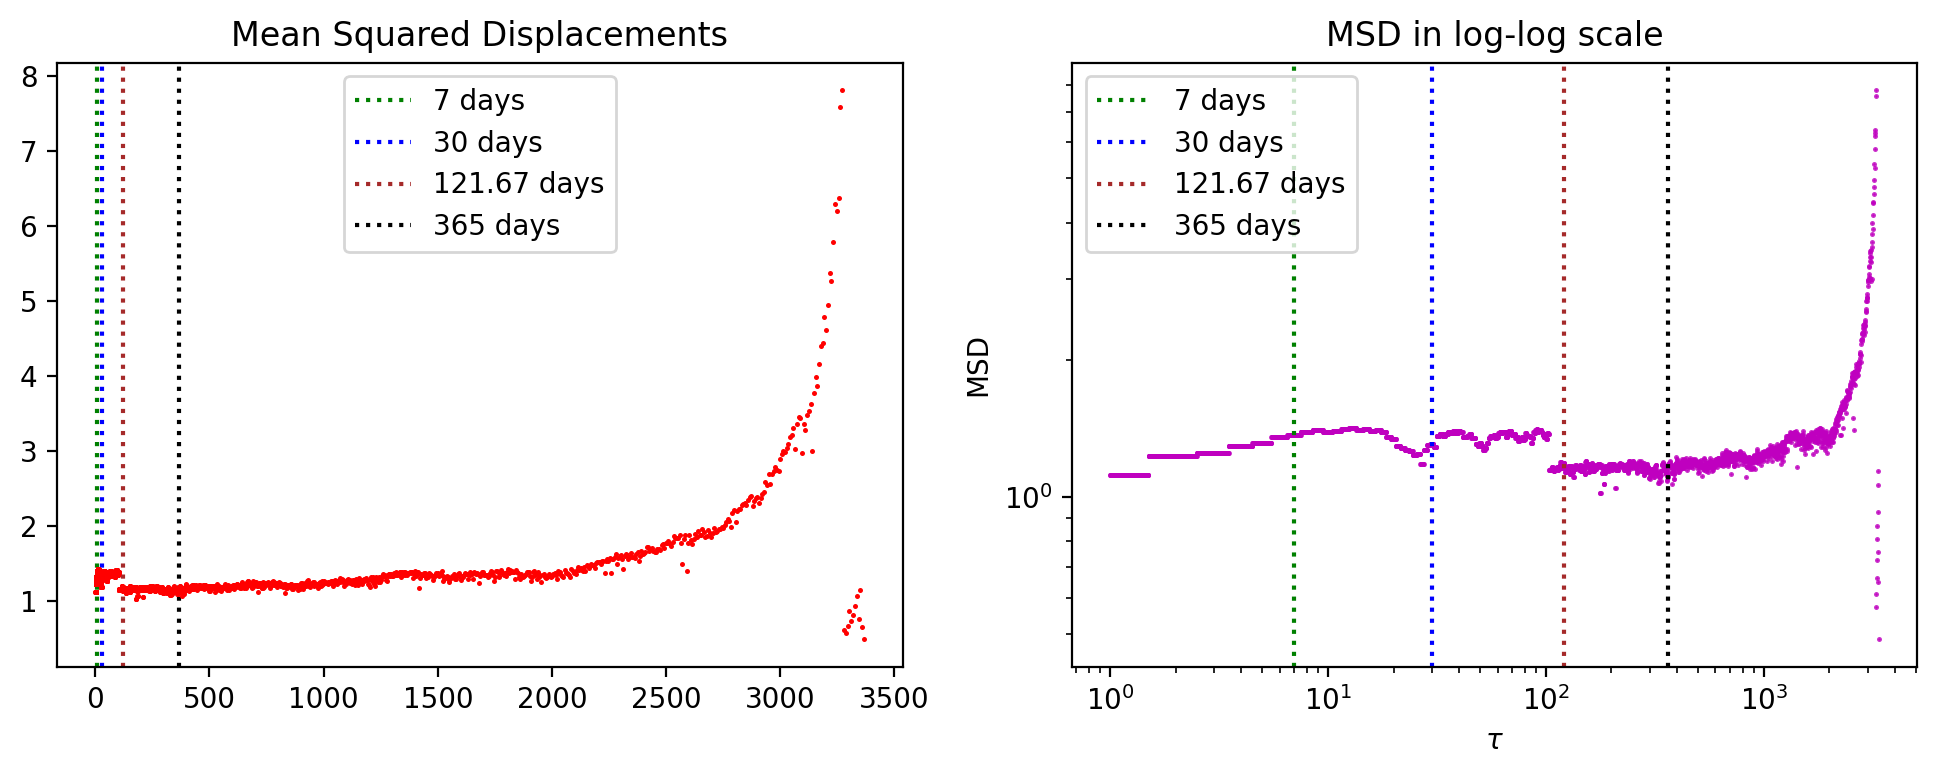

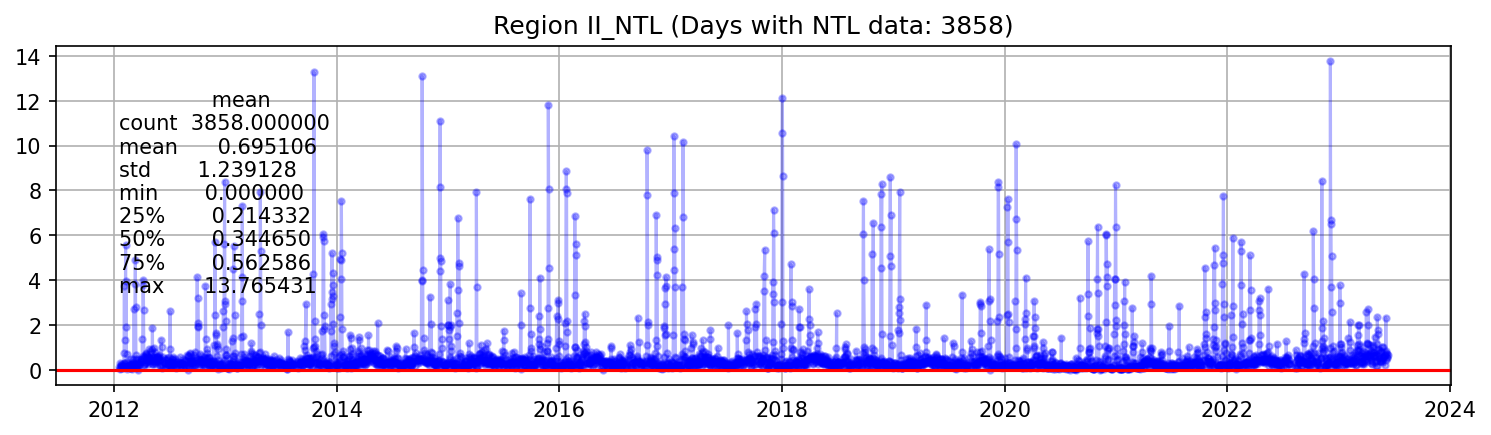

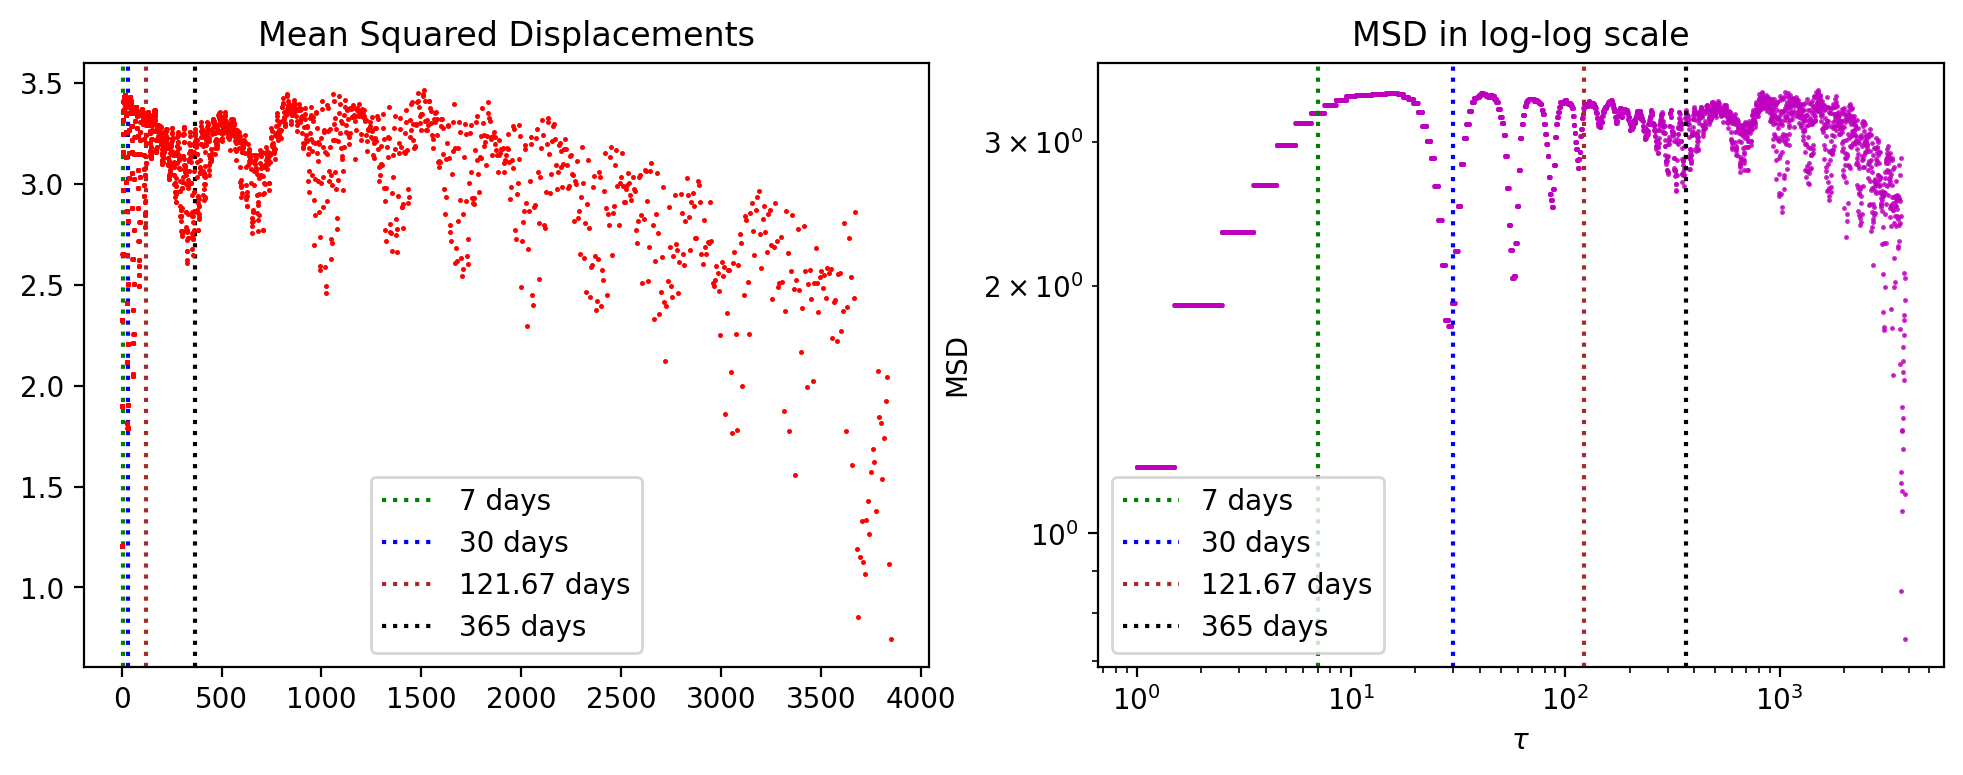

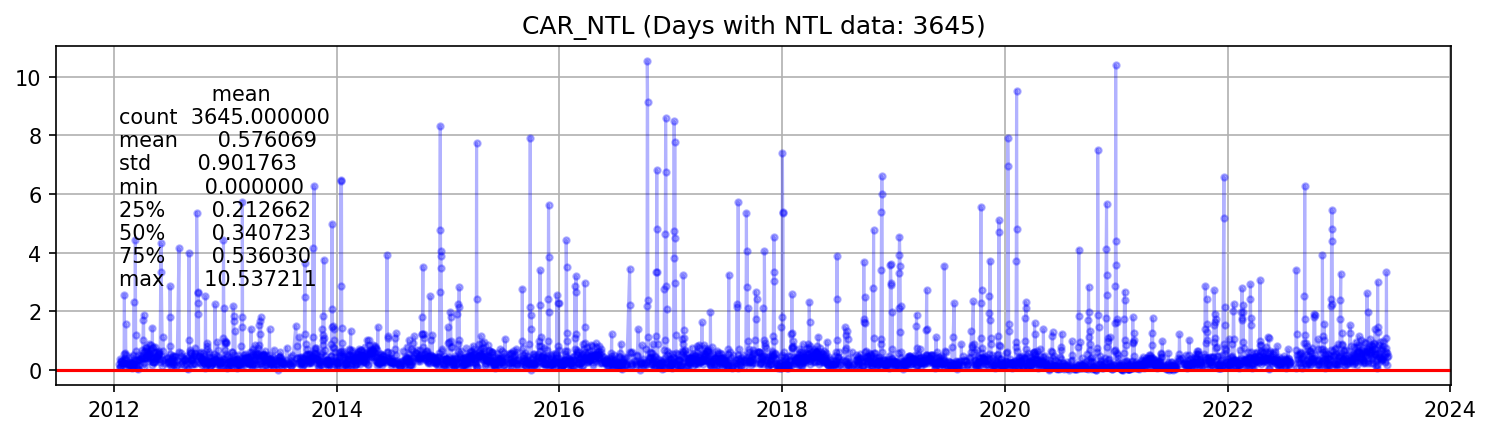

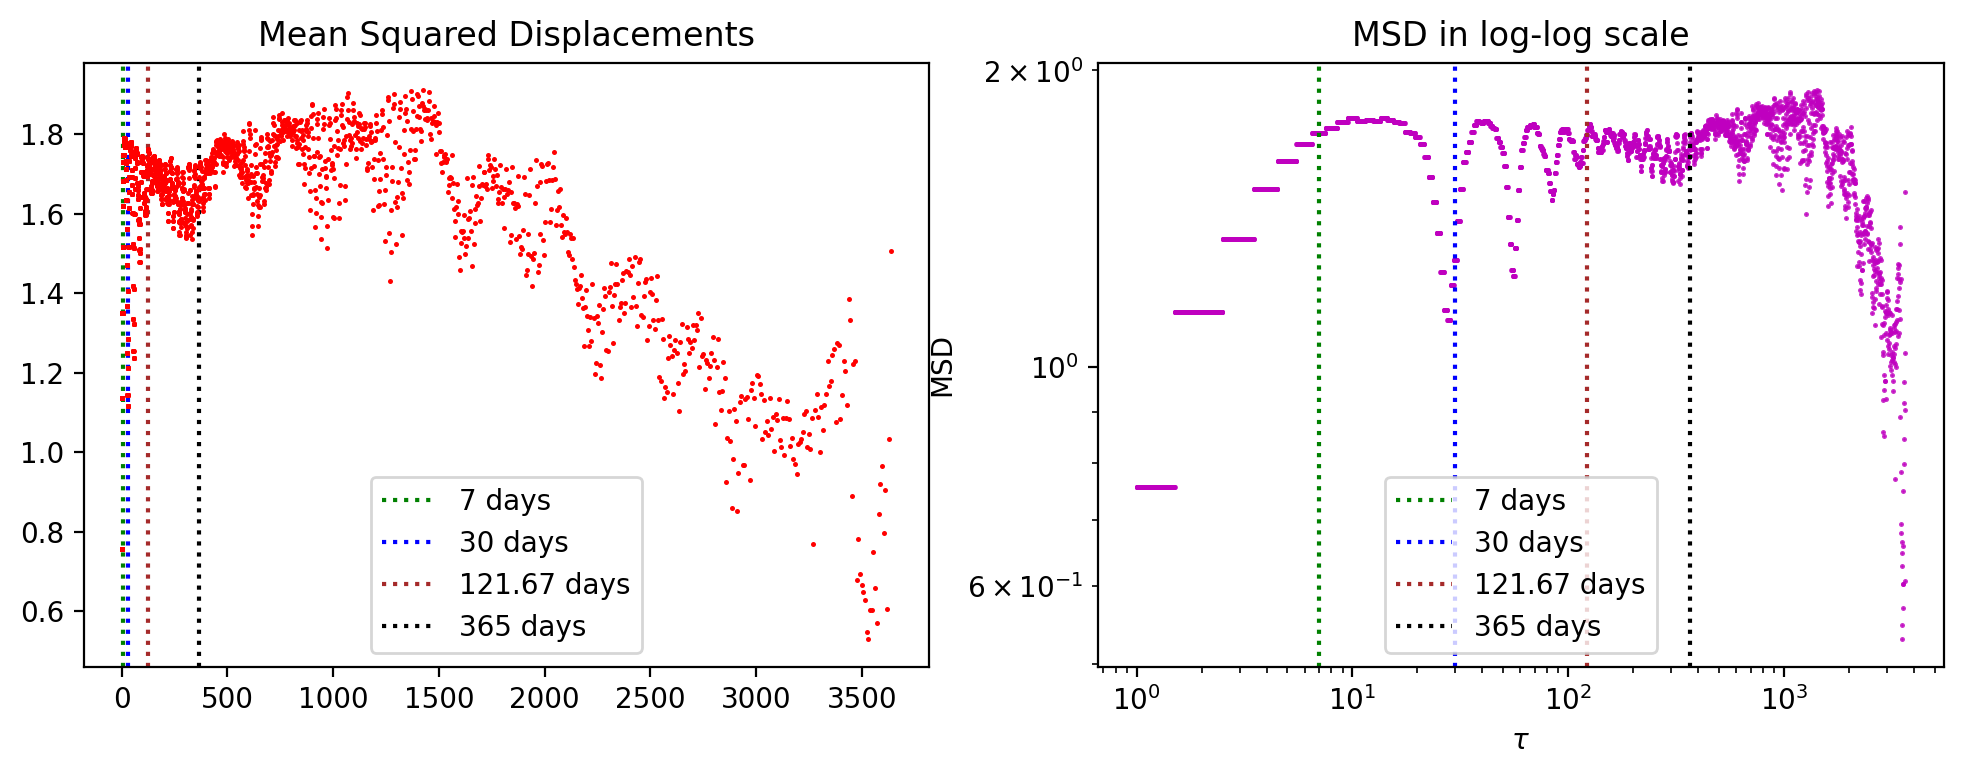

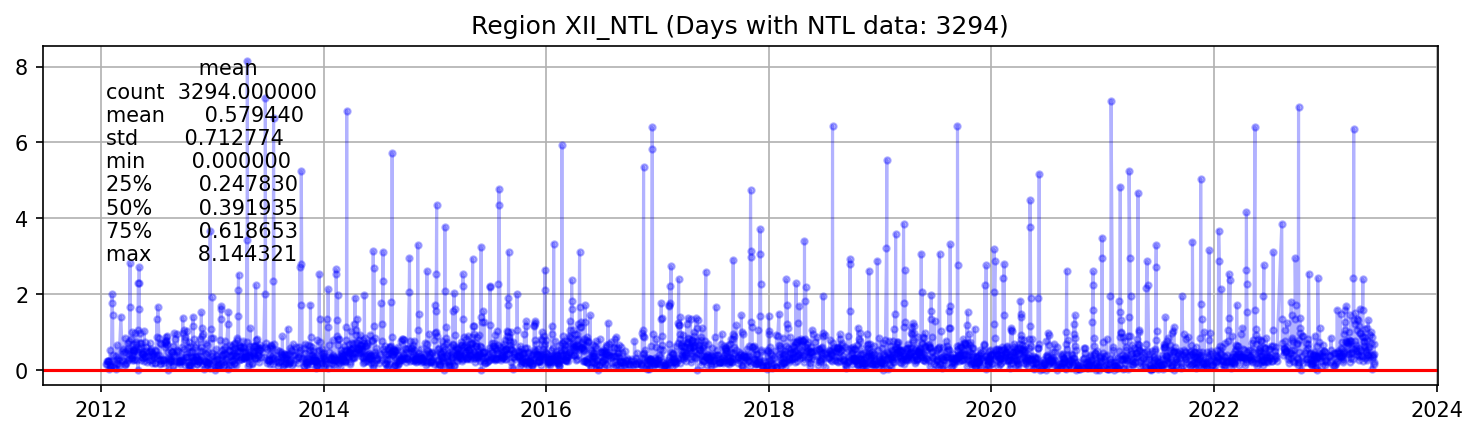

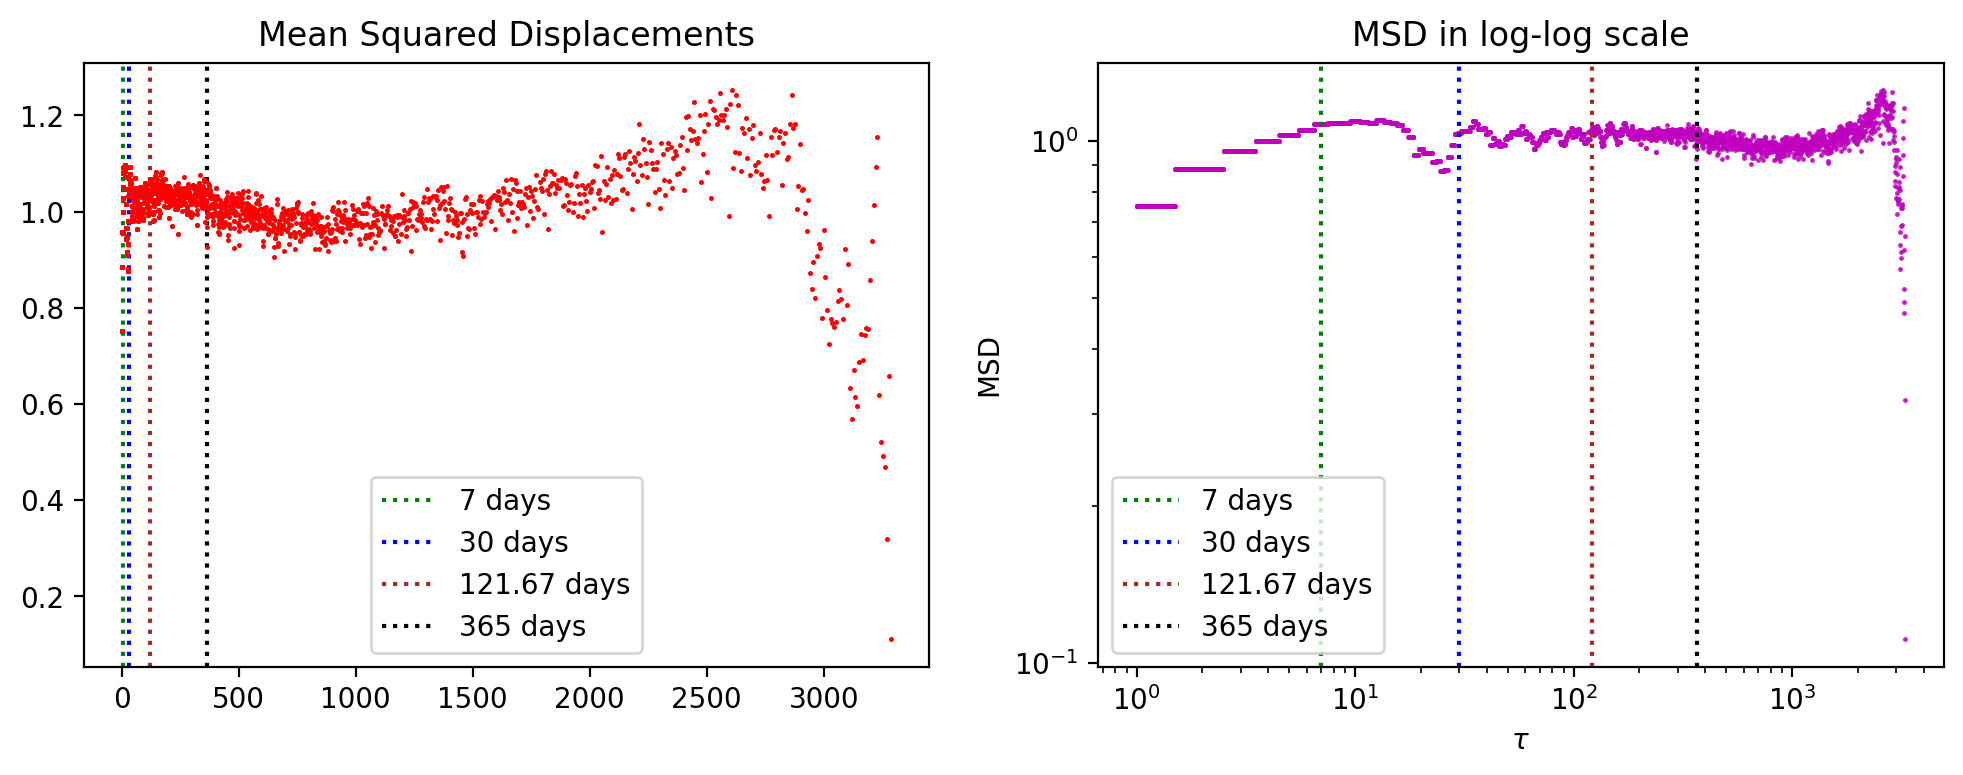

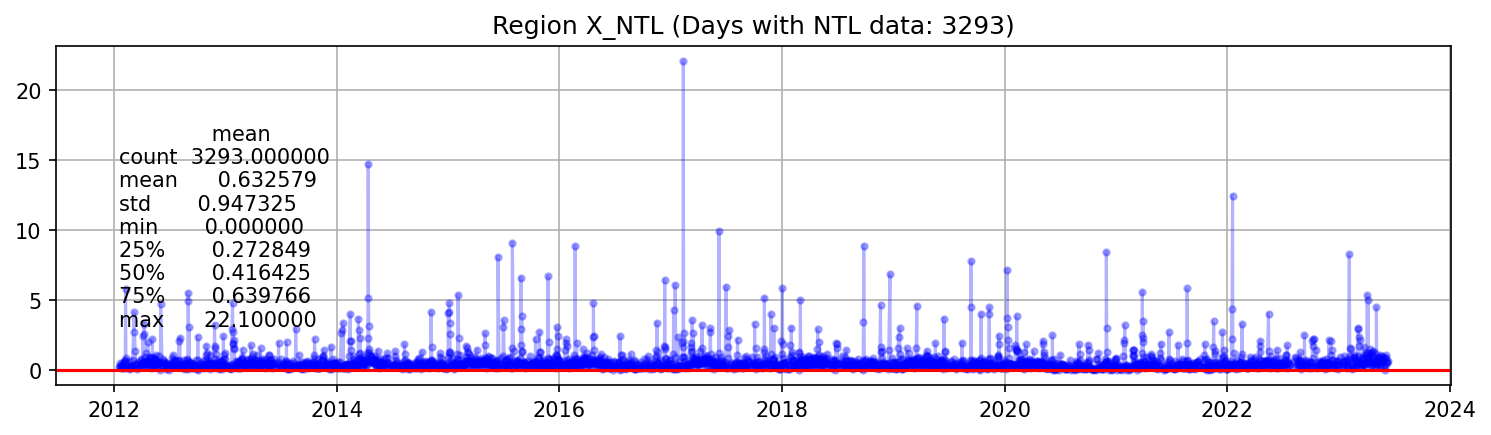

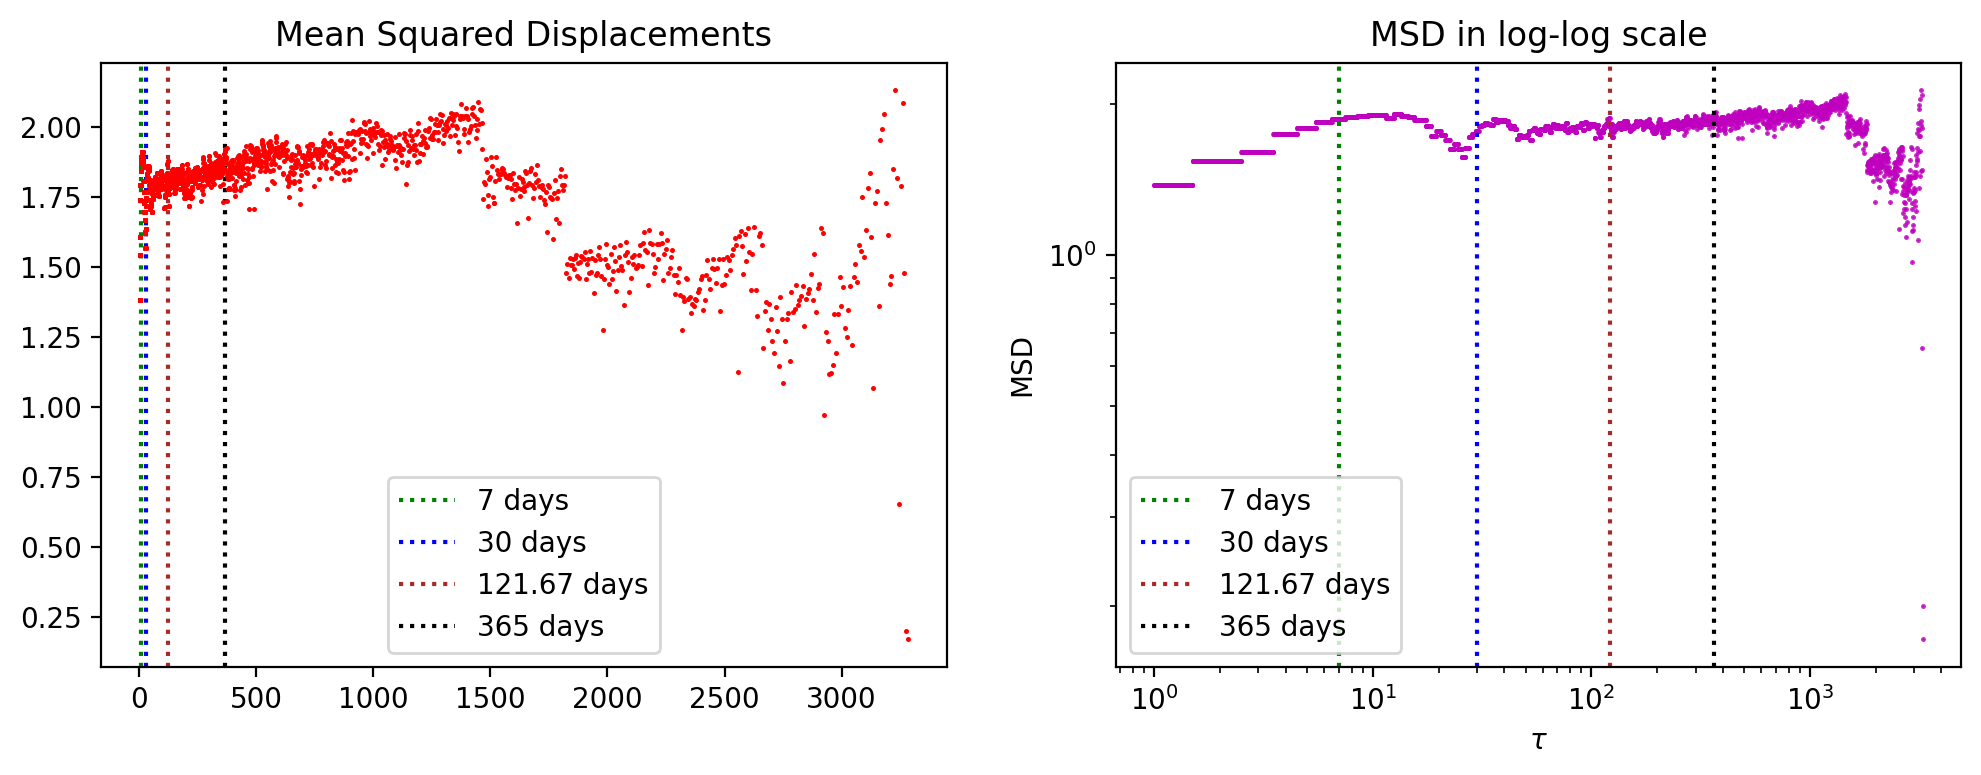

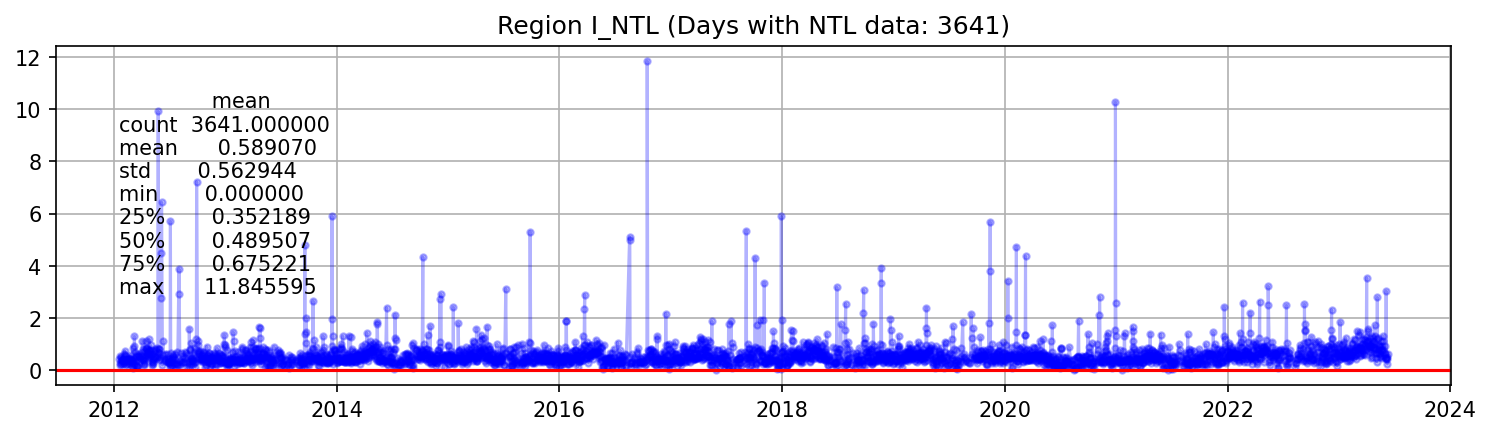

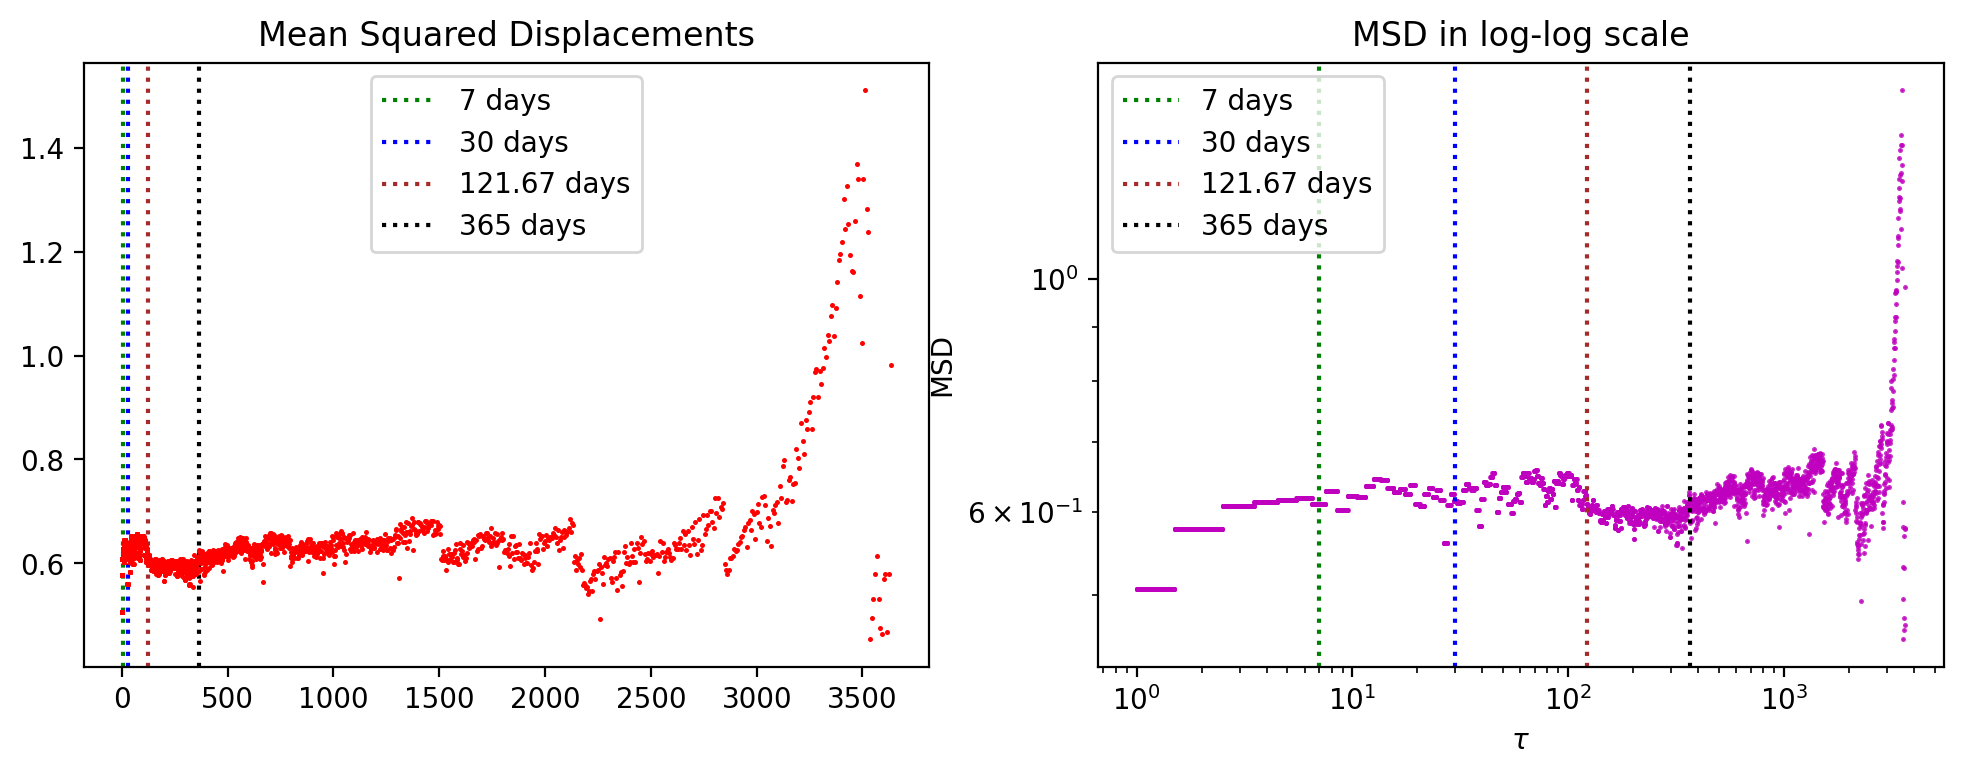

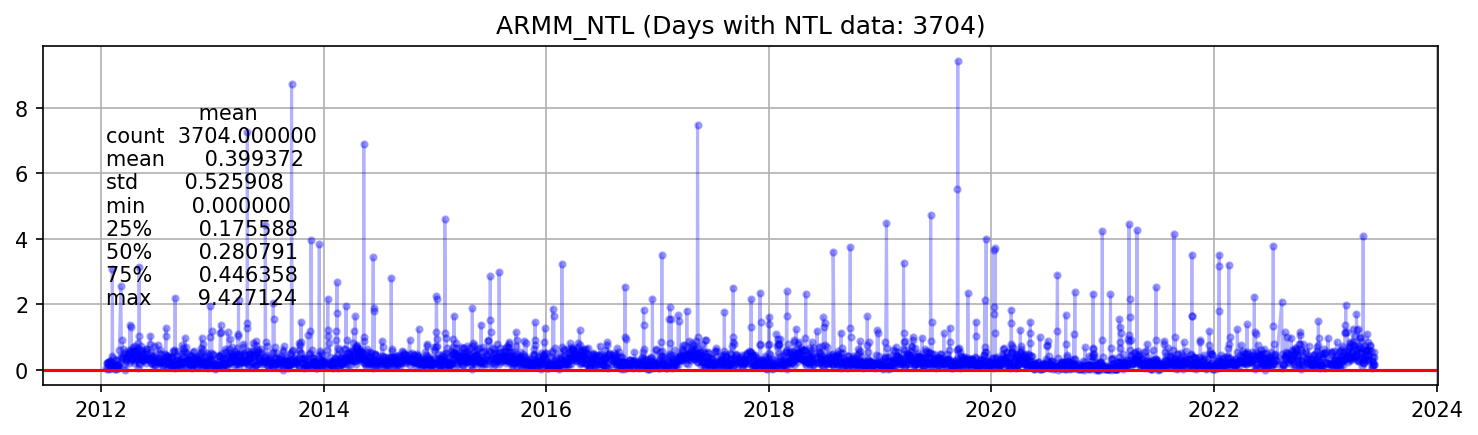

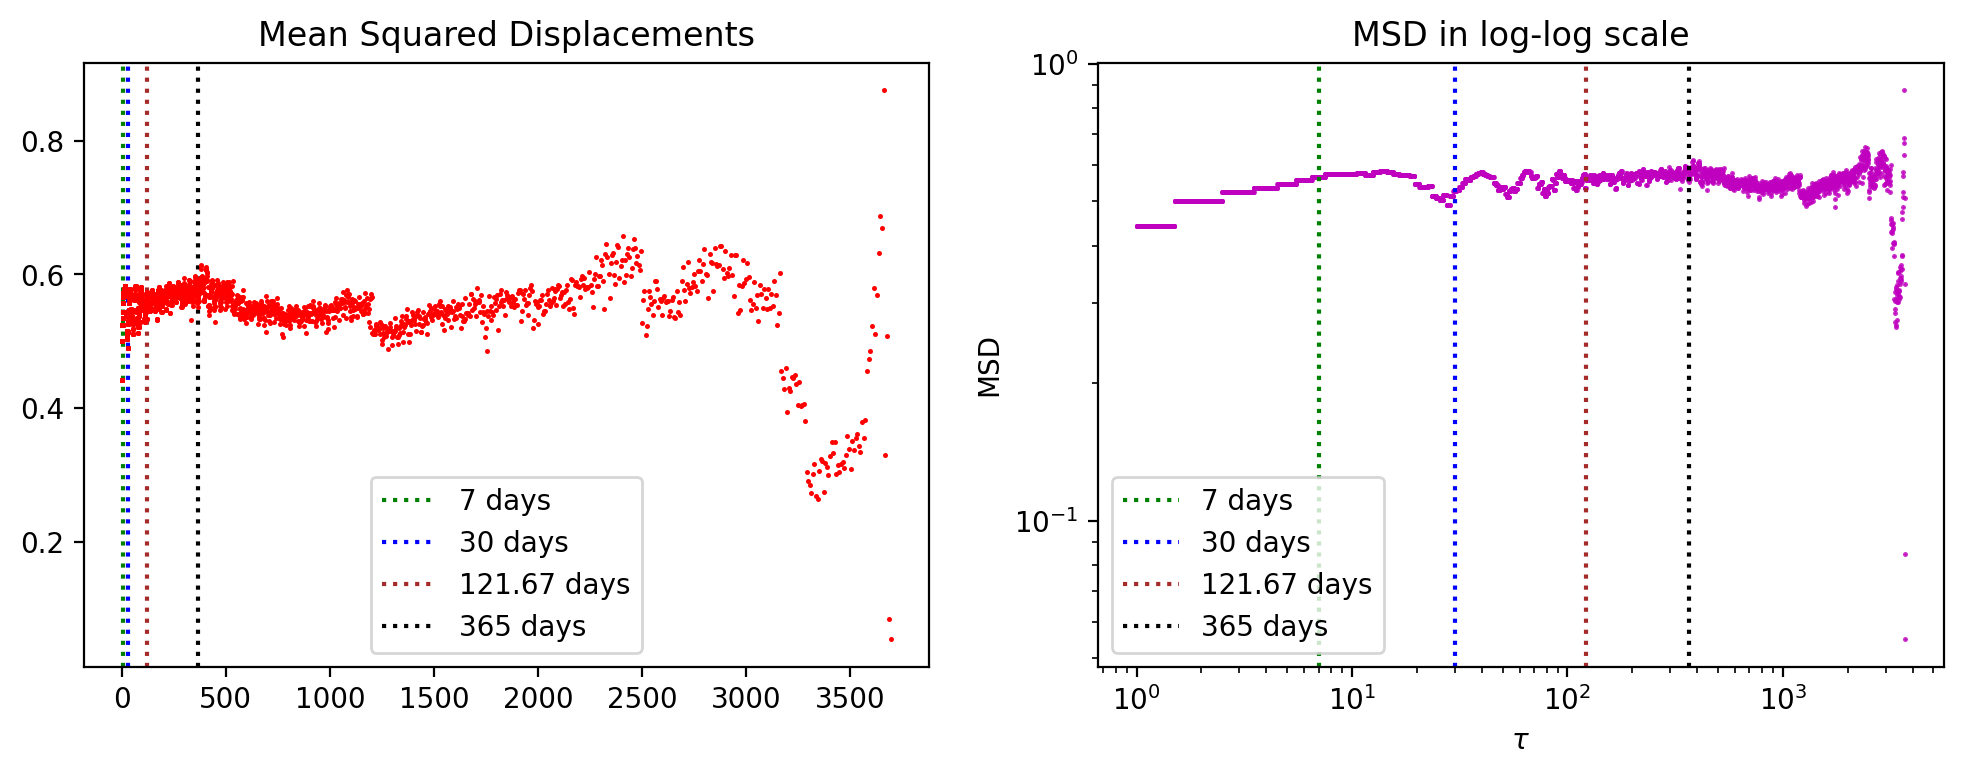

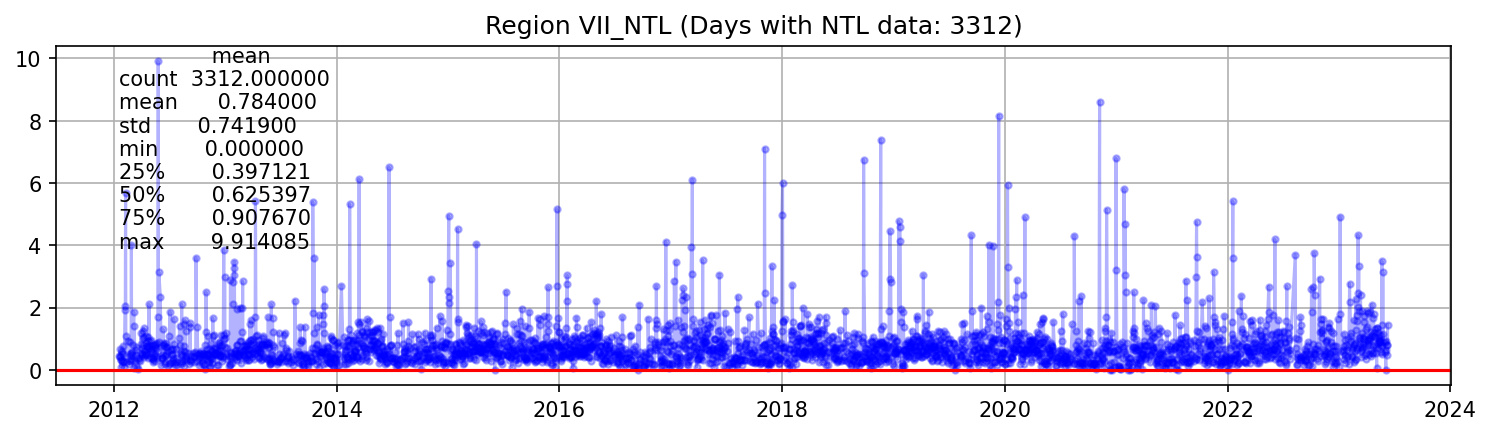

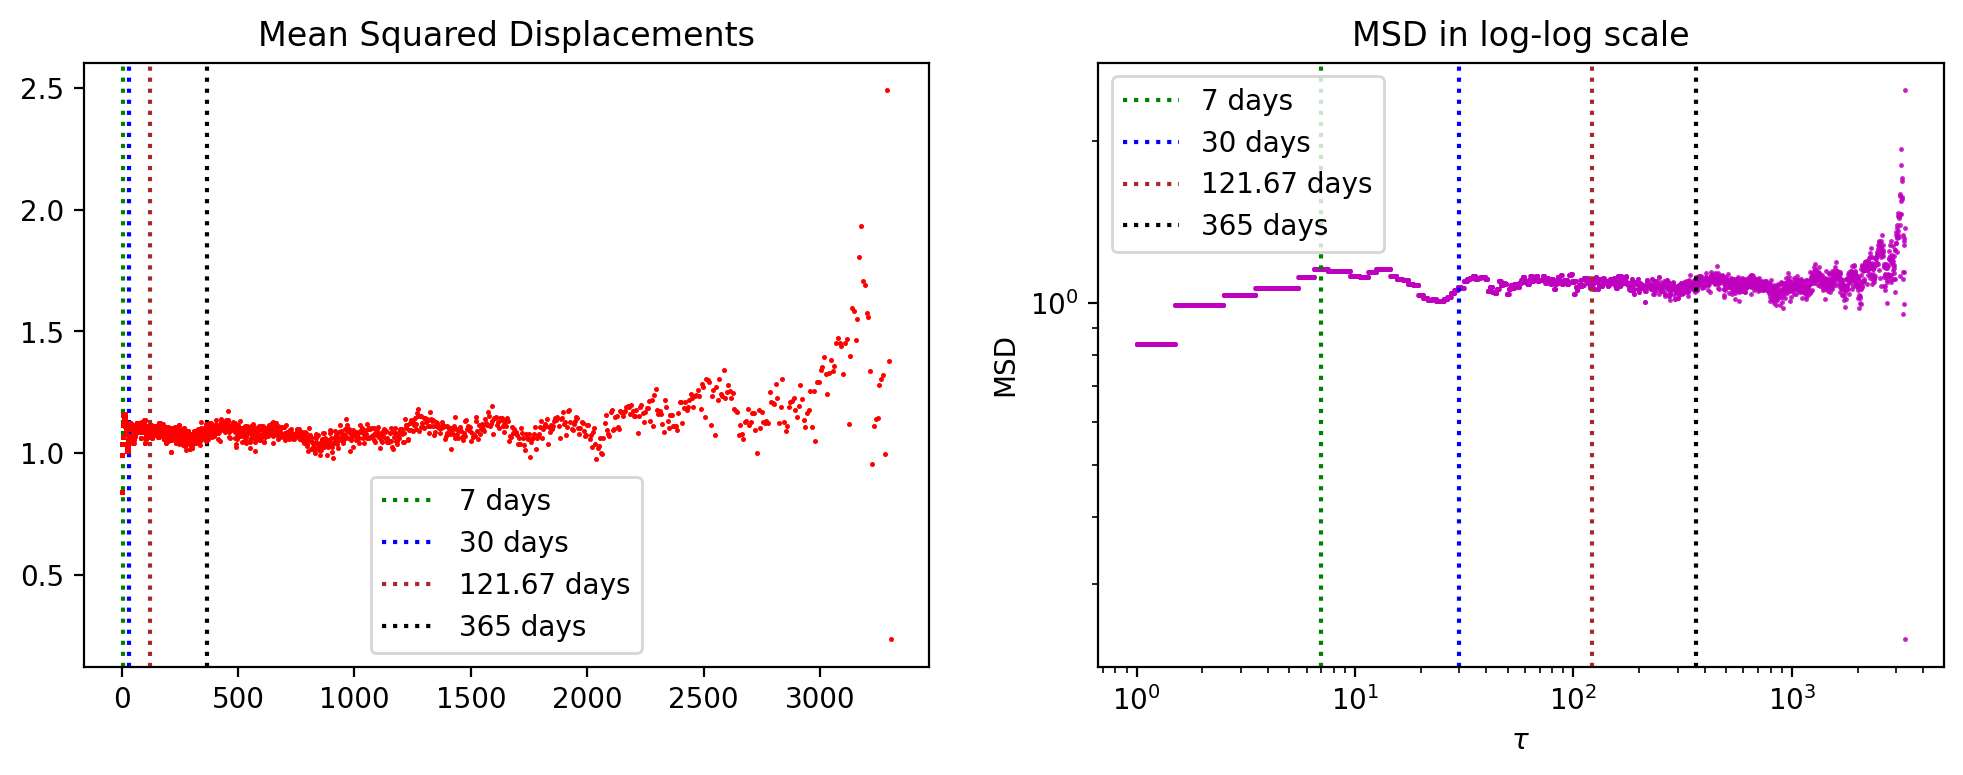

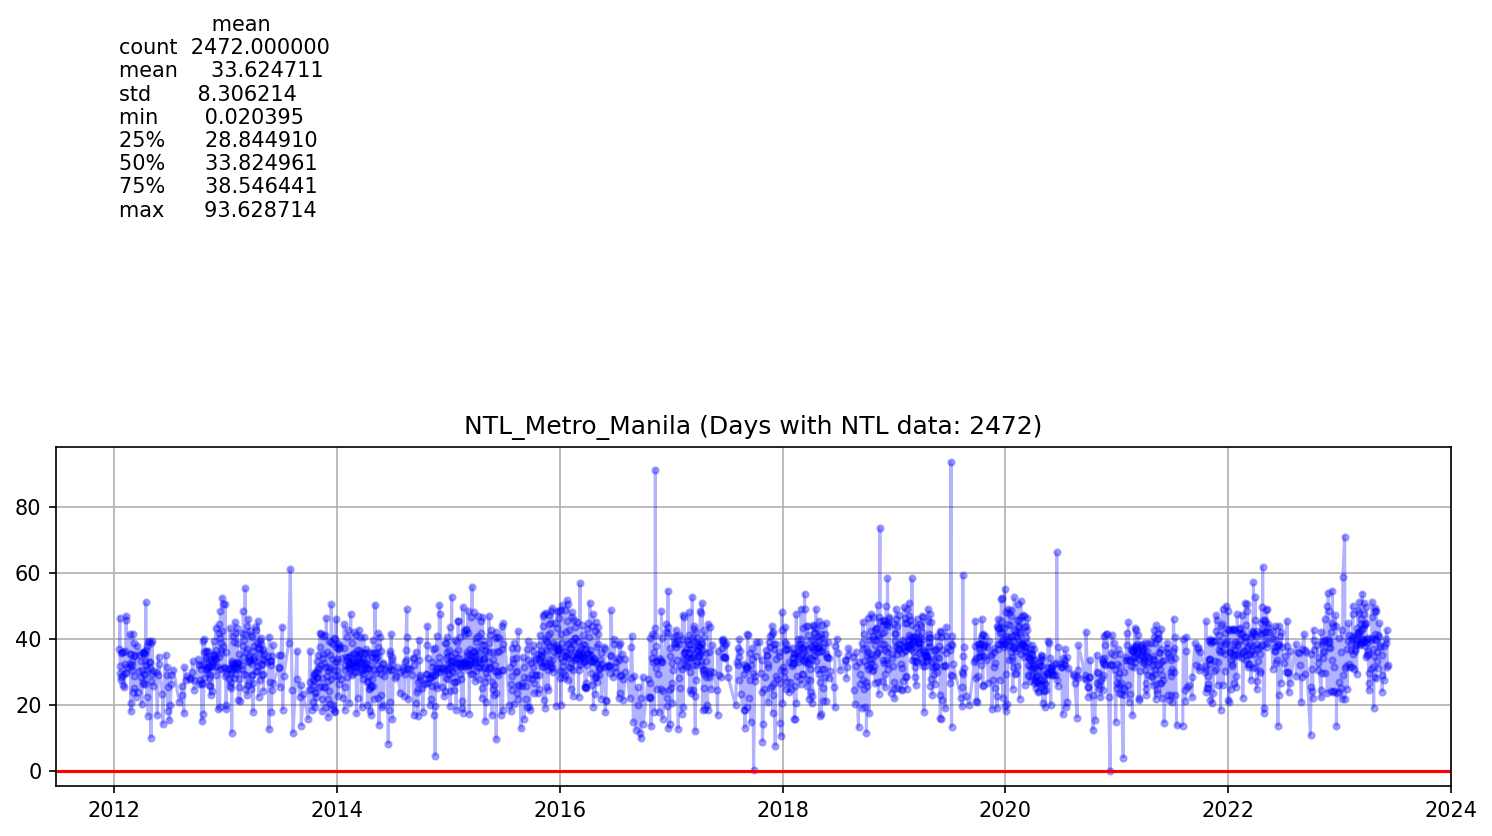

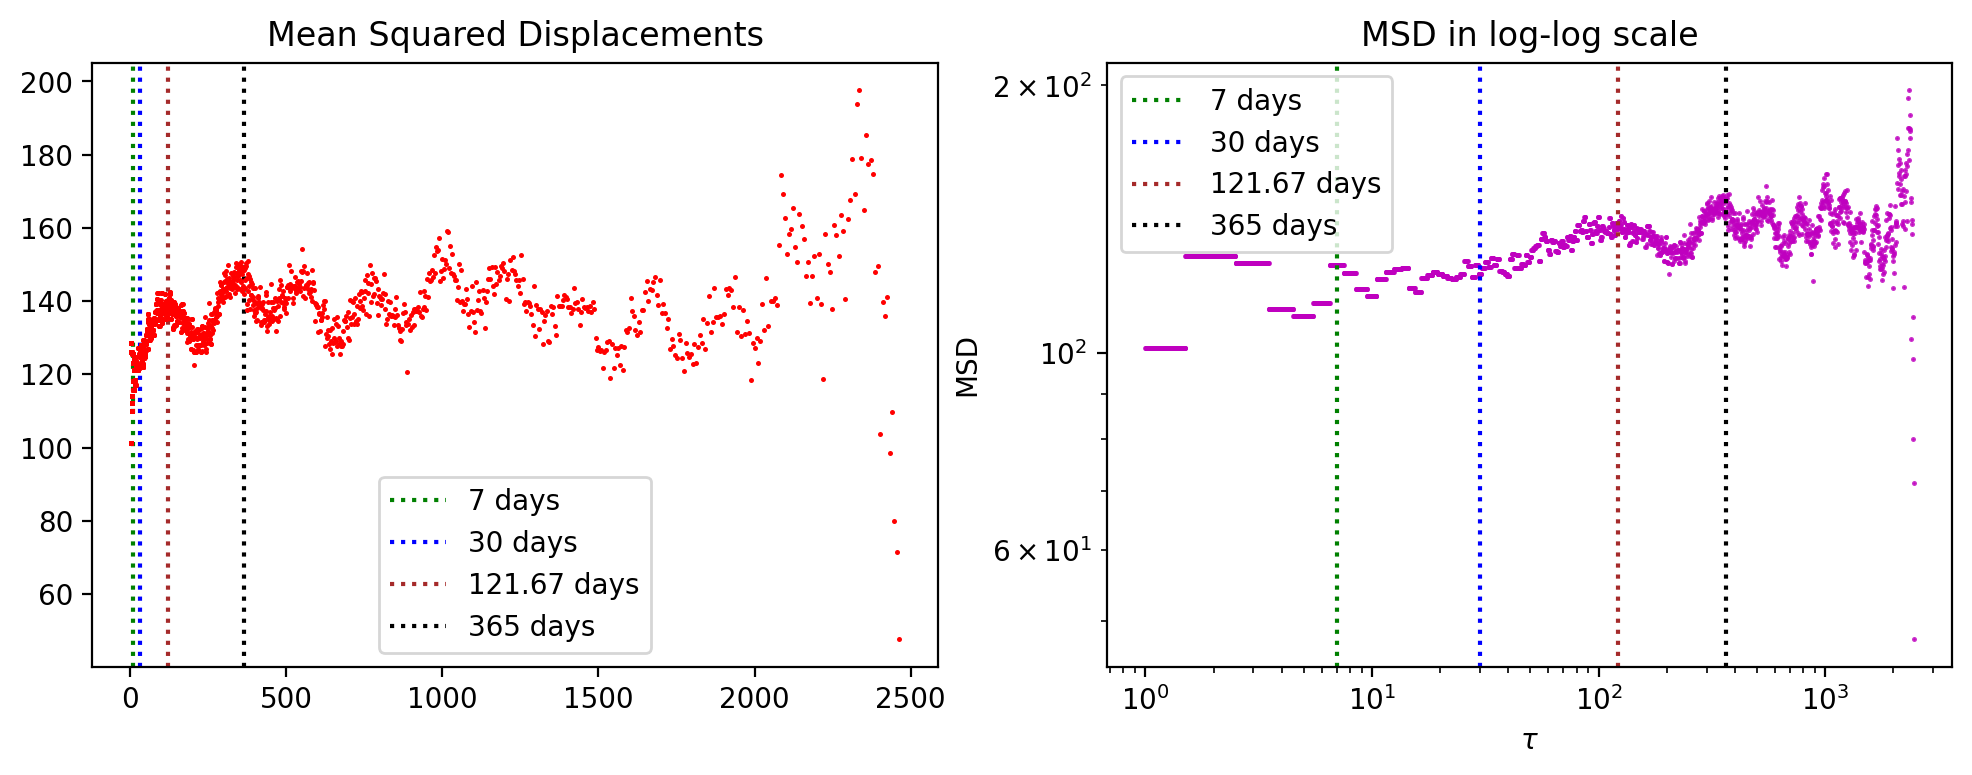

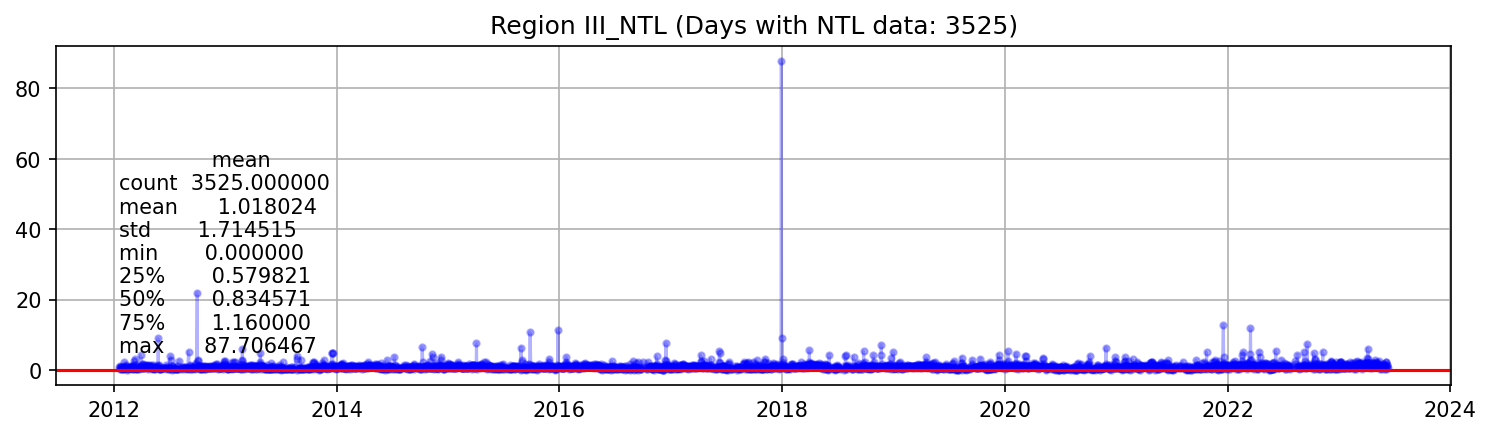

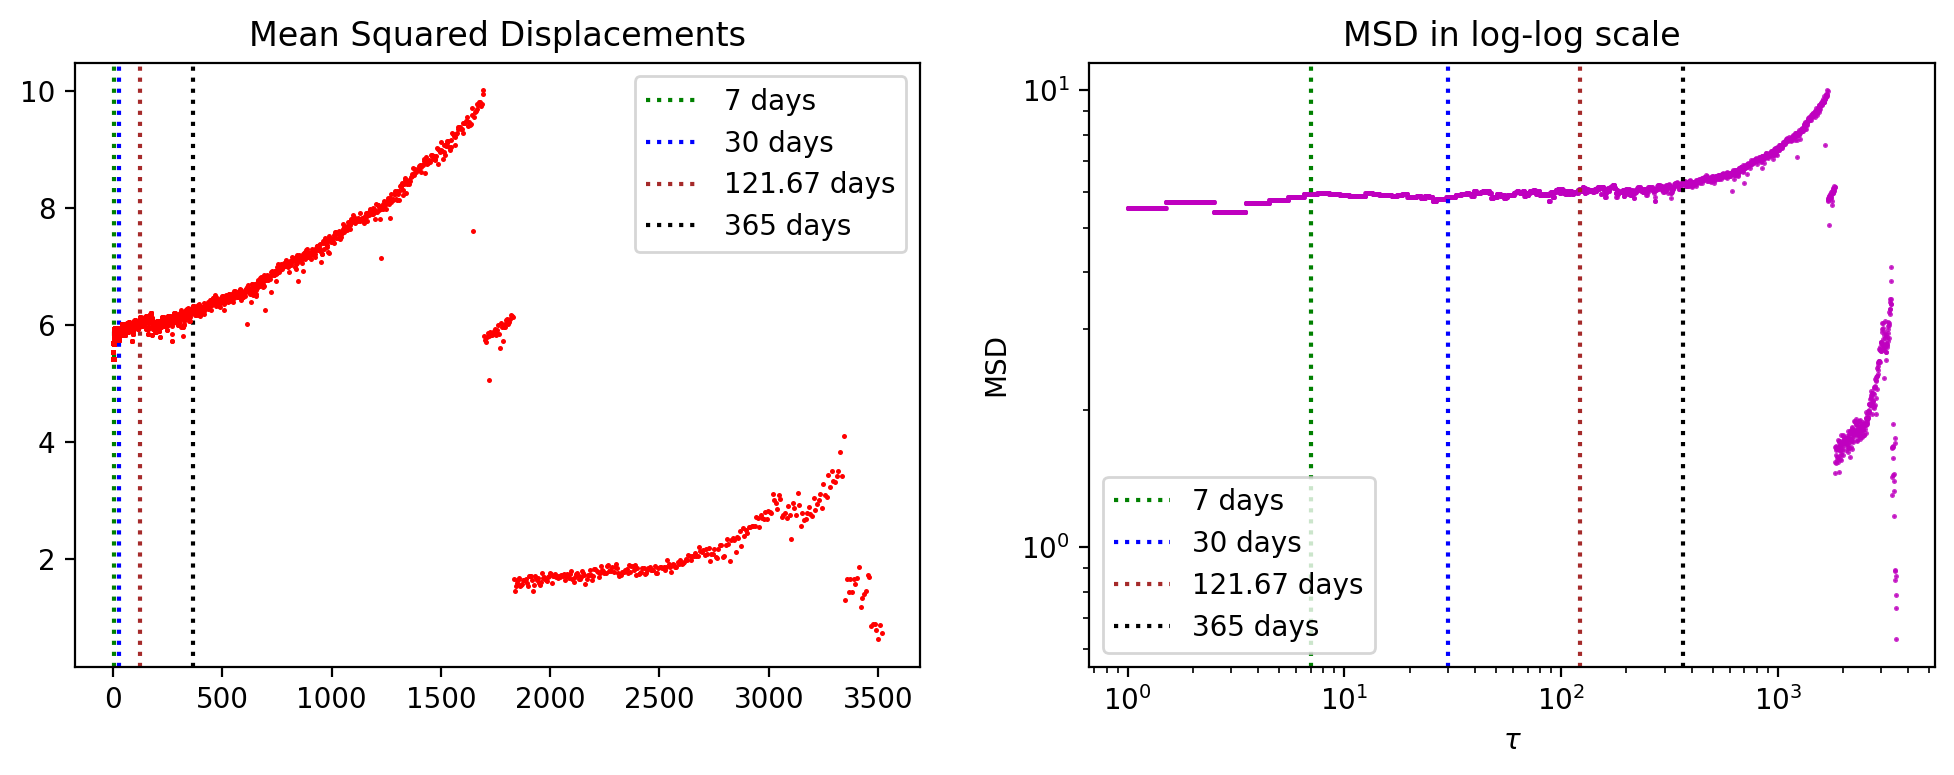

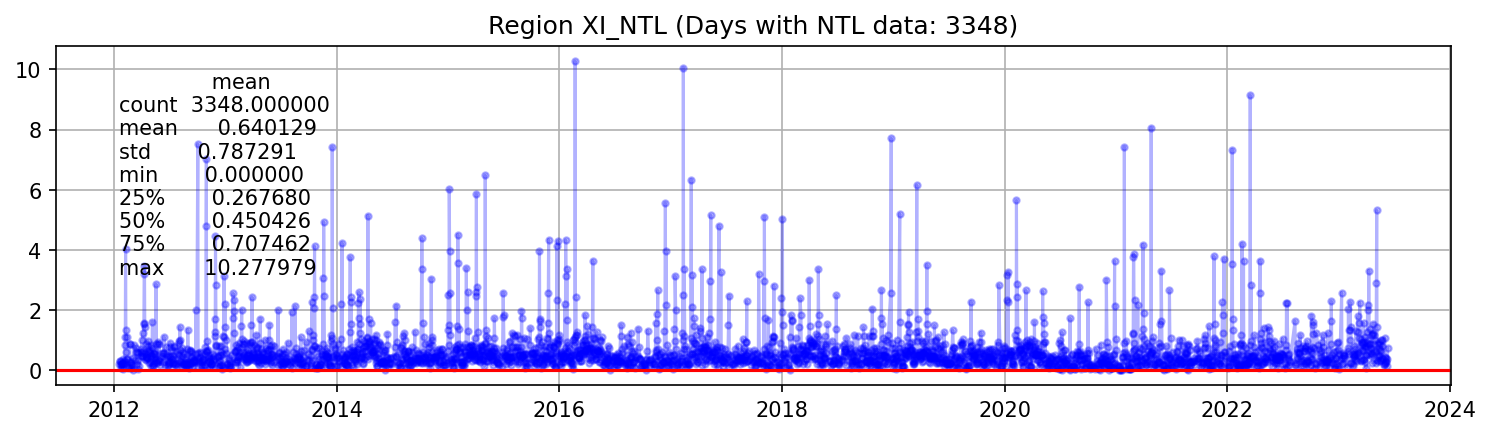

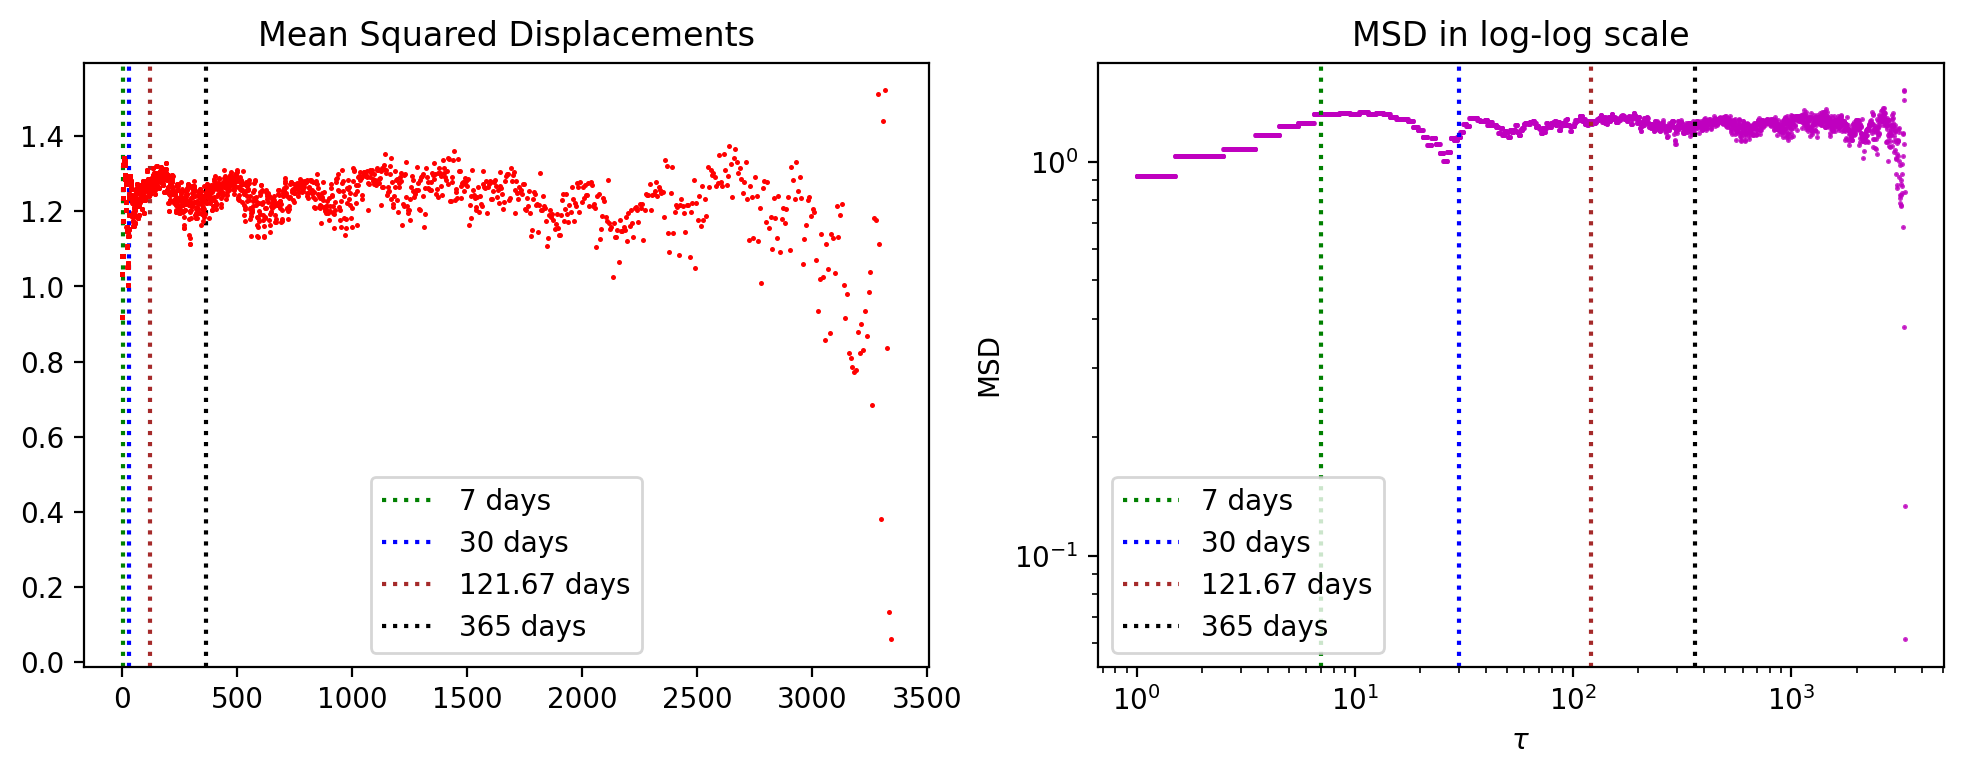

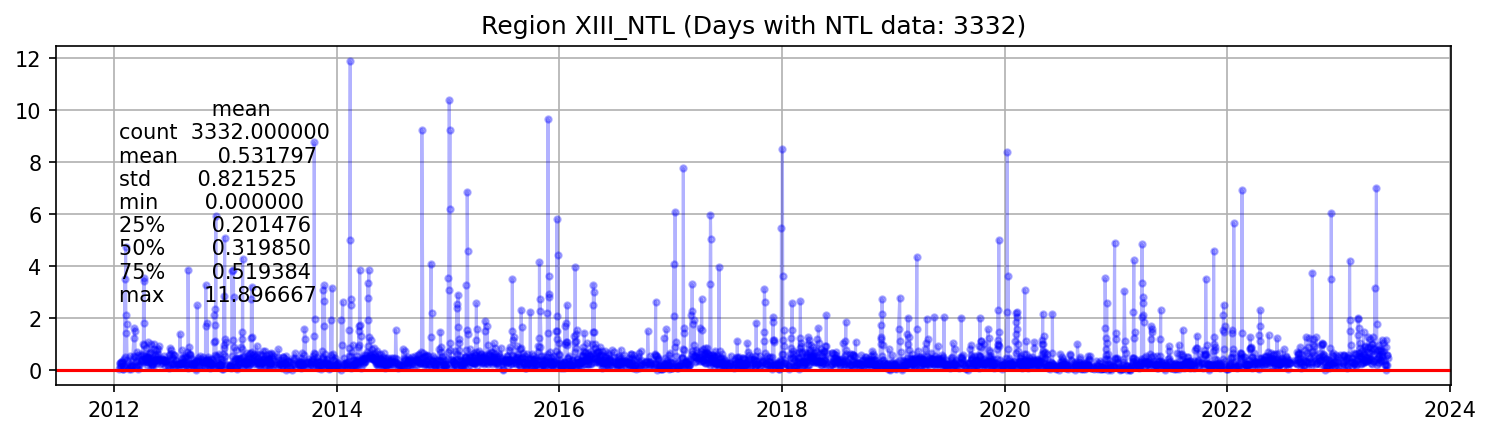

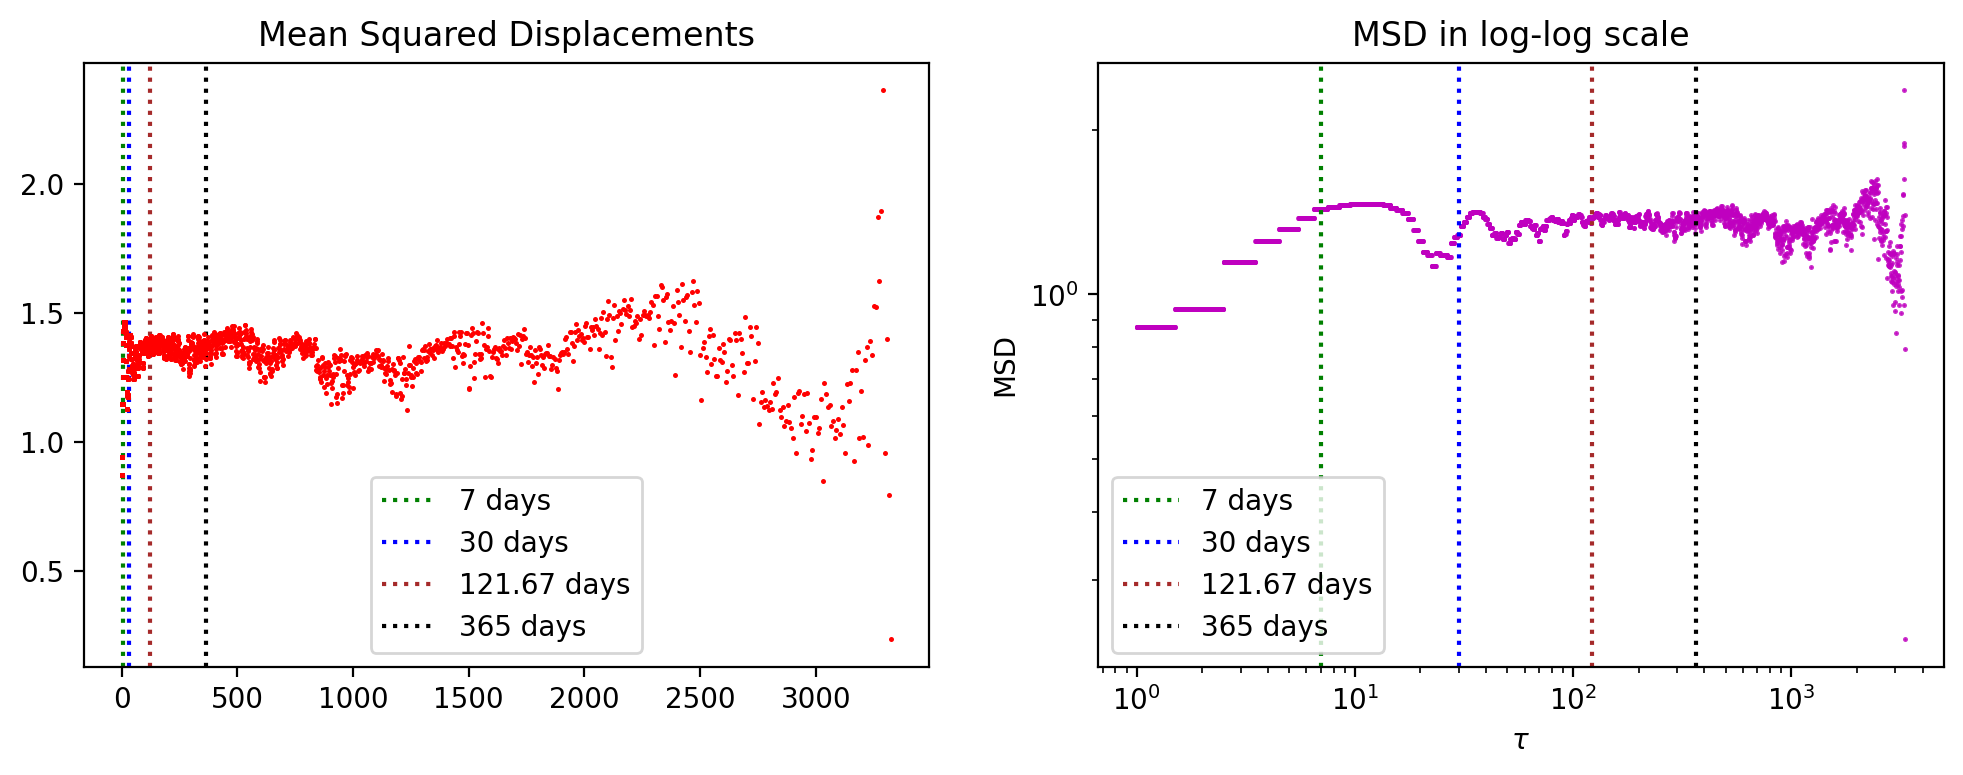

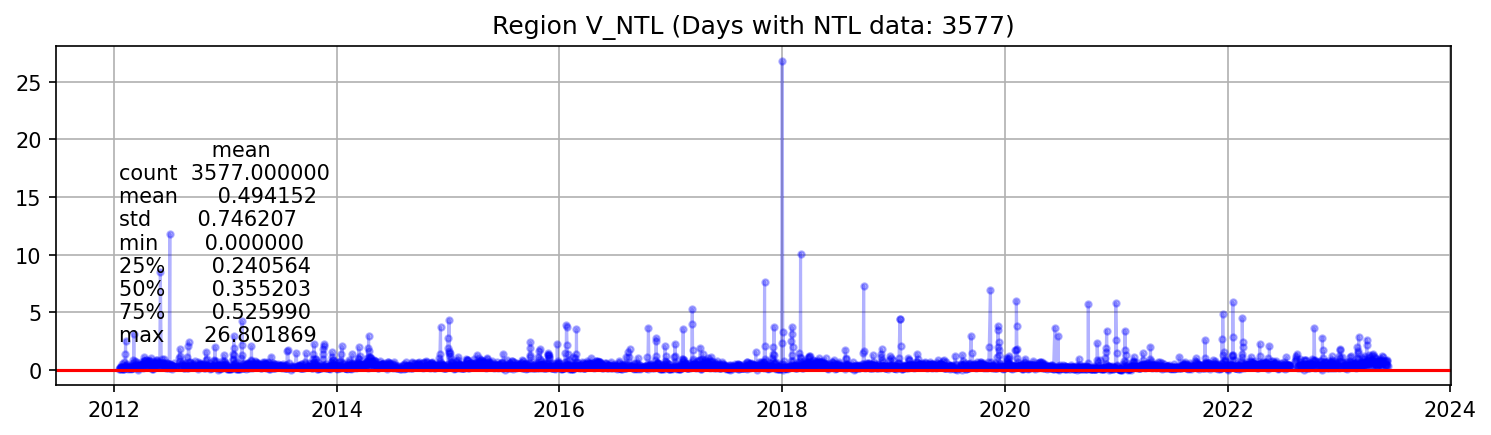

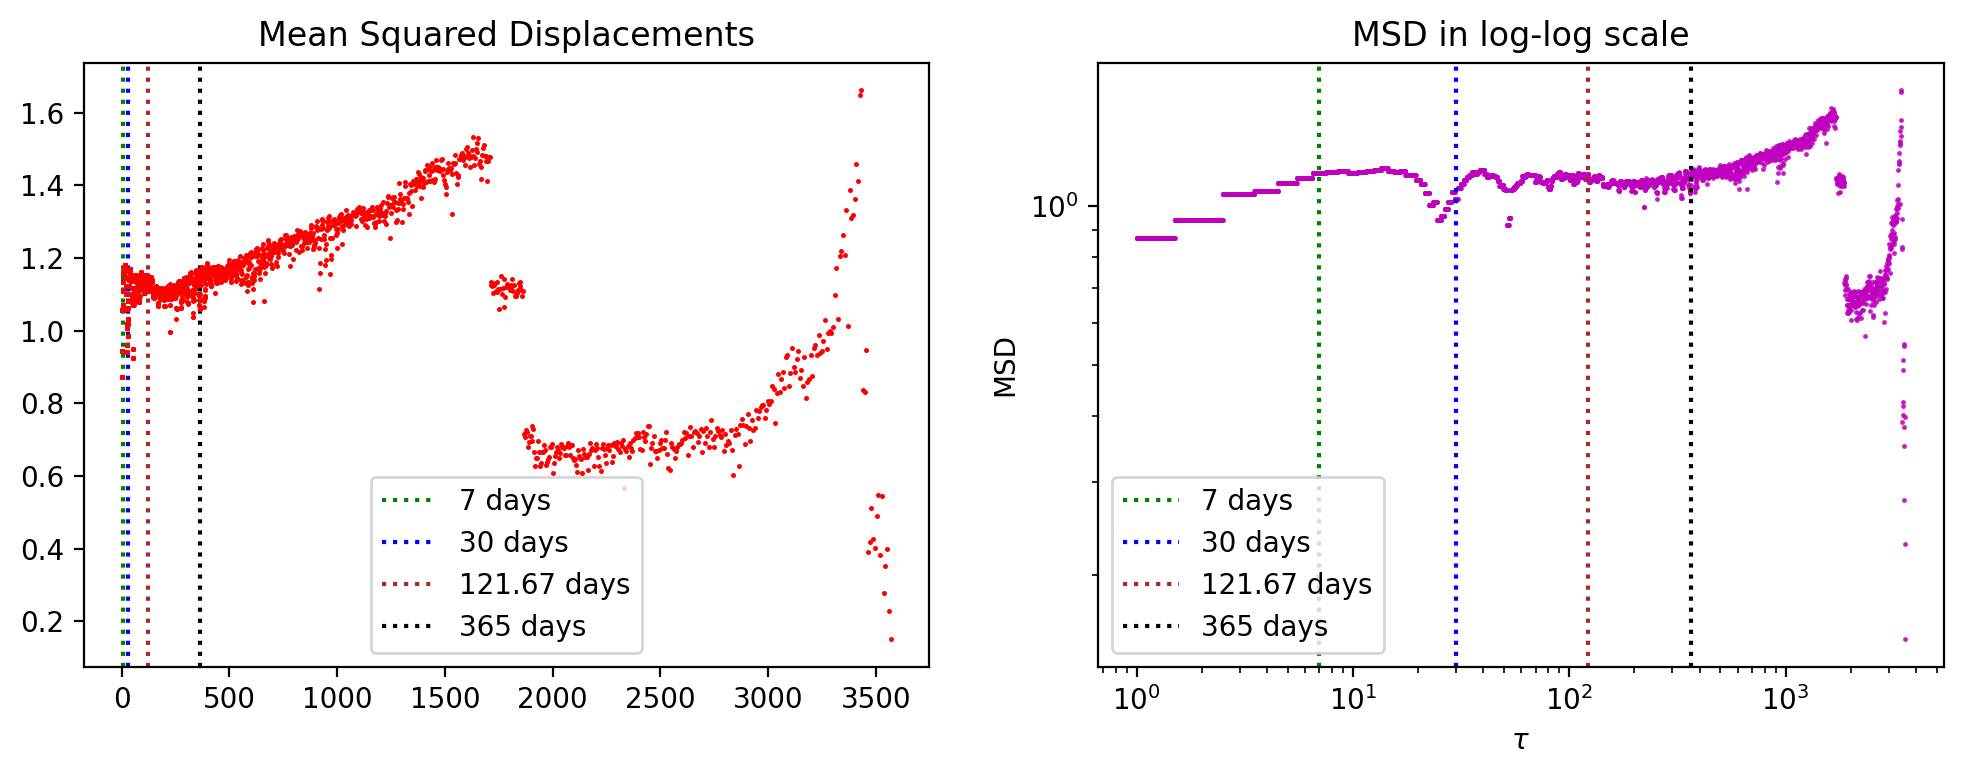

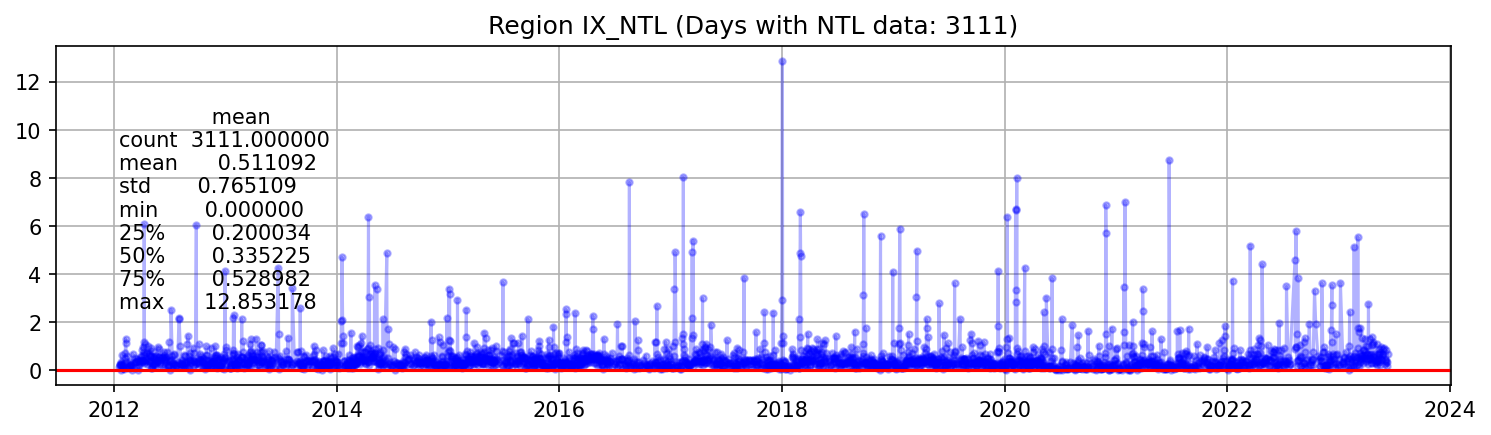

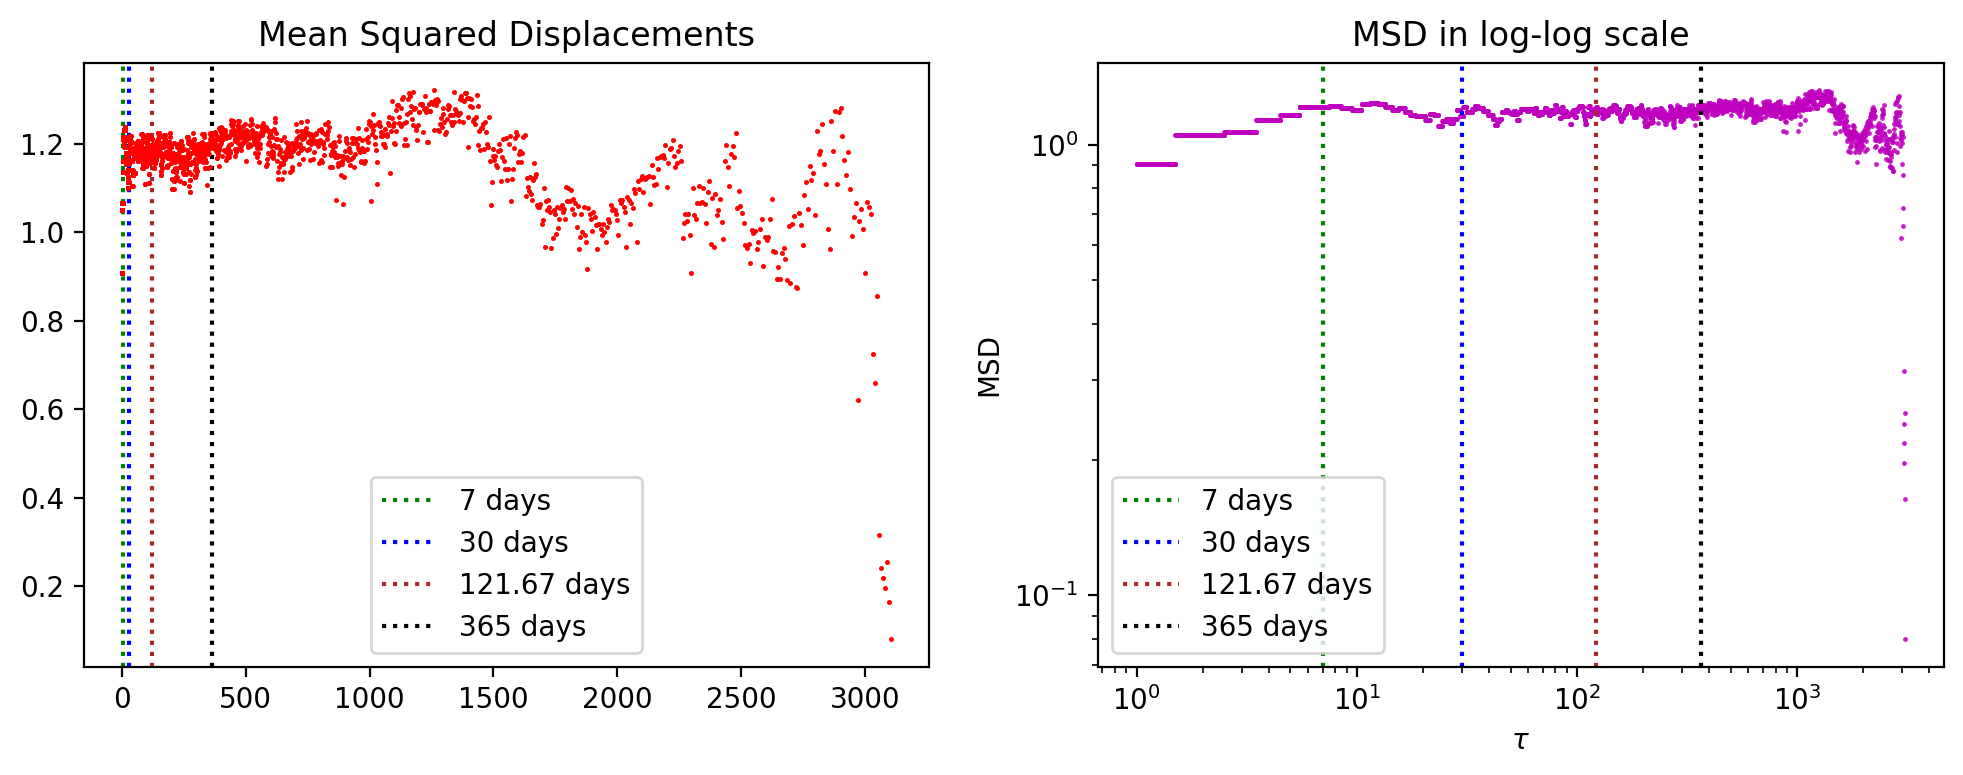

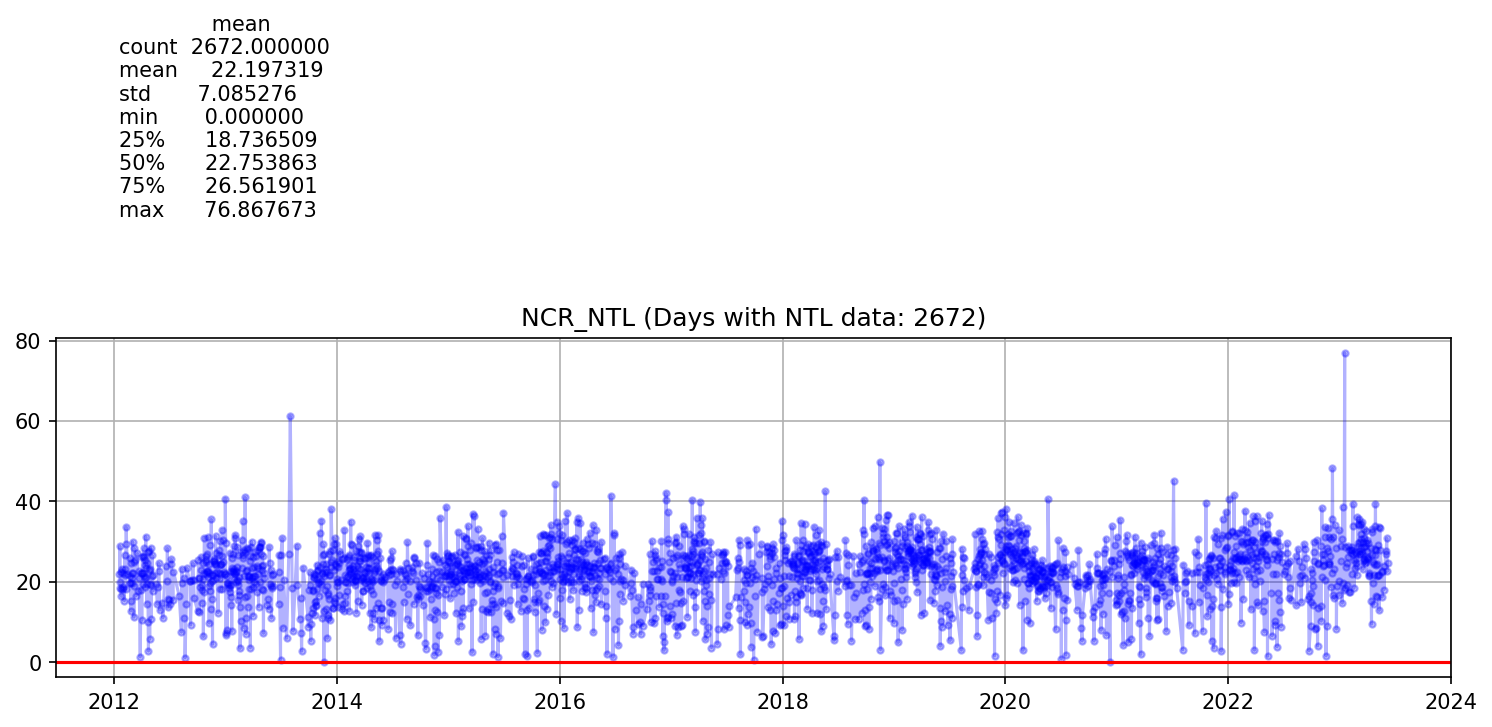

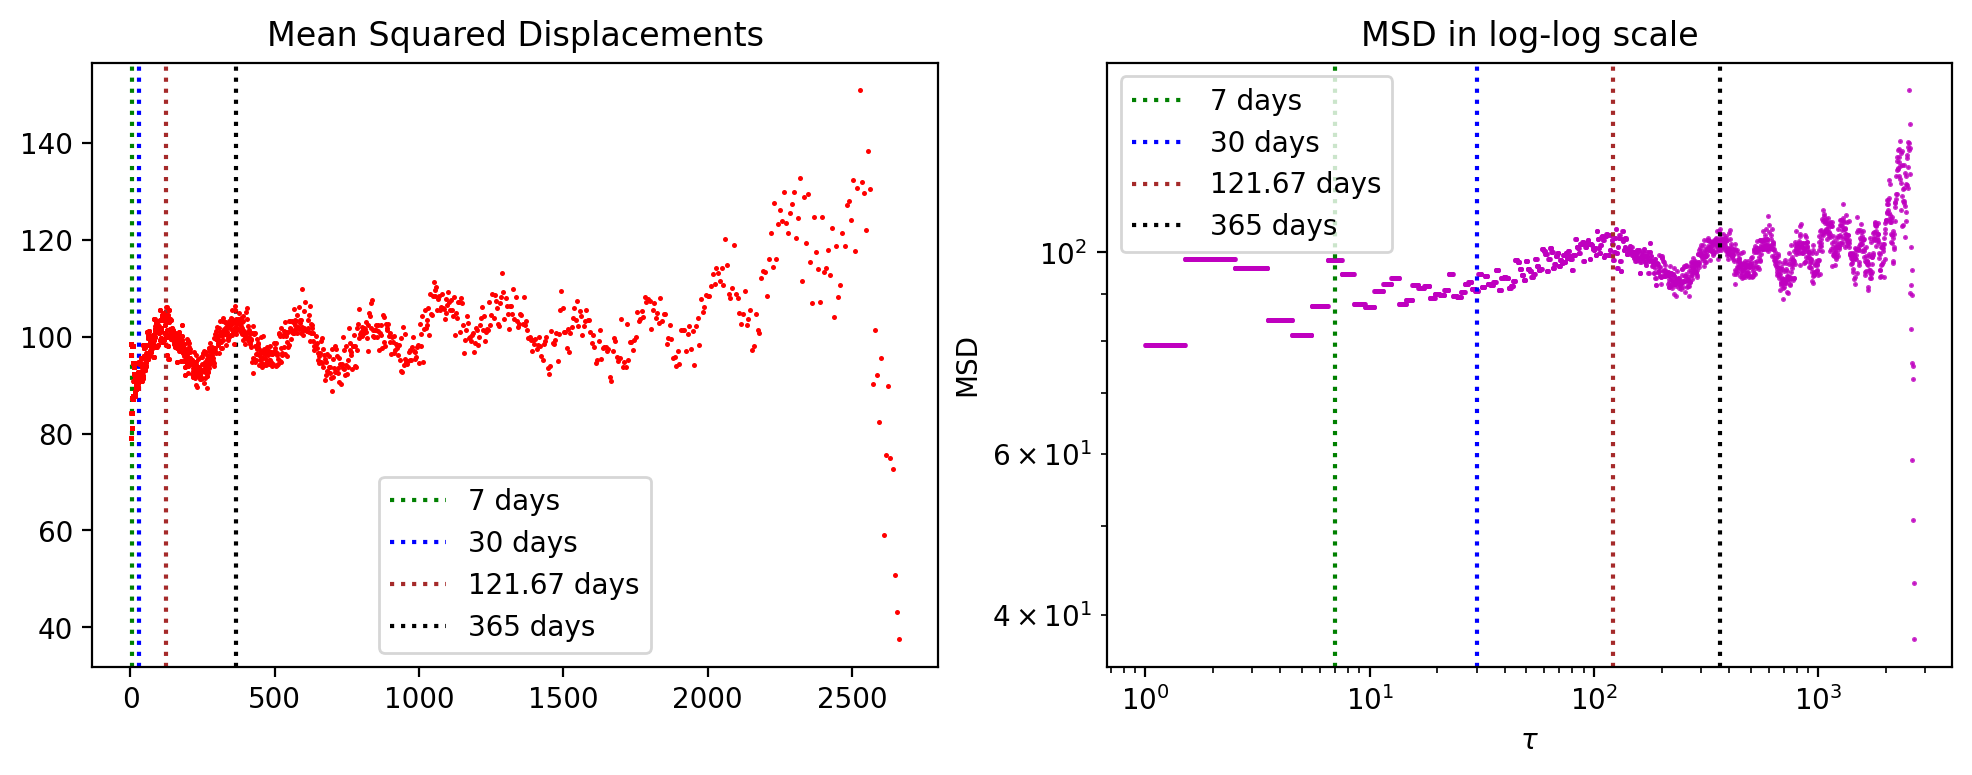

In [85]:
for NTL_data in tqdm(regional_NTL):
    data = pd.read_csv(data_path+NTL_data, parse_dates=True, index_col = 0)
    plt.figure(dpi = 150, figsize = (12,3))
    plt.grid()
    plt.plot(data, 'b.-', alpha = 0.3)
    plt.axhline(0, color = 'r')
    plt.title(NTL_data[:-4] + ' (Days with NTL data: ' + str(len(data)) + ')')
    plt.text(datetime.date(2012, 1, 19),data['mean'].mean()*5, str(data.describe()))
    plt.savefig("../results/" + str(NTL_data[:-4]) + ".png")
    
    n_tau = len(data)
    # n_tau = 100
    tau_vals = np.logspace(0,np.log10(n_tau), n_tau)
    delta_vals = np.round(tau_vals/dt).astype(int)

    n = len(data)
    n_samp = 1
    n_tau = len(tau_vals)
    dx_tau = np.empty((n, n_tau))*np.nan

    for i, tau in tqdm(enumerate(tau_vals)):
      delta = delta_vals[i]
      data_trunc = data[:-1*delta]
      data_shift = data[delta:]
      dx = data_shift.values - data_trunc.values
      dx_tau[:len(dx), i] = dx.T

    msd_tau = np.empty((n_tau, n_samp))*np.nan
    for i, tau in enumerate(tau_vals):
      dx2_sum = np.nansum(dx_tau[:, i]**2)
      denom = n-delta_vals[i]
      msd_tau[i, i_samp] = dx2_sum/denom

    plt.figure(dpi = 200, figsize = (12,4))
    plt.subplot(121)
    plt.axvline(7, color='green', ls=':', label = "7 days")
    plt.axvline(30, color='blue', ls=':', label = "30 days")
    plt.axvline(365/3, color='brown', ls=':', label = "121.67 days")
    plt.axvline(365, color='k', ls=':', label = "365 days")
    plt.plot(tau_vals, msd_tau, 'ro', ms = 0.8)
    plt.title('Mean Squared Displacements')
    plt.legend()

    plt.subplot(122)
    plt.plot(tau_vals, msd_tau, 'mo', alpha = 0.8, ms = 0.8)
    msd_theo = tau_vals
    plt.axvline(7, color='green', ls=':', label = "7 days")
    plt.axvline(30, color='blue', ls=':', label = "30 days")
    plt.axvline(365/3, color='brown', ls=':', label = "121.67 days")
    plt.axvline(365, color='k', ls=':', label = "365 days")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\tau$")
    plt.ylabel("MSD")
    plt.title('MSD in log-log scale')
    plt.legend()
    
    plt.savefig("../results/" + str(NTL_data[:-4]) + "_MSD.png")